# Amazon Book Recommender System

Data Source:
https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/


Author: Yucian Hong

In [33]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import SVD
from surprise.dataset import Reader, Dataset

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('selected.csv')
df = df[['customer_id','product_id','star_rating']]
df.rename(columns={'customer_id':'userid'})
df.head(10)

,customer_id,product_id,star_rating
0,53000124,0805076069,4
1,49355567,0060820810,5
2,50057481,0297844091,5
3,49750558,0971220603,4
4,50774468,0380007789,3
...,...,...,...
133677,53075795,0345372050,1
133678,53071138,0440215757,5
133679,53075795,0679751203,5
133680,53092736,0345348656,5


,customer_id,product_id,star_rating
0,53000124,0805076069,4
1,49355567,0060820810,5
2,50057481,0297844091,5
3,49750558,0971220603,4
4,50774468,0380007789,3
5,46134316,0465014569,5
6,52960913,0525948775,5
7,45273033,0465023282,5
8,50230169,0451526341,4
9,50001942,0307276902,4


## preprocessing

In [10]:
# data overview: check data size, column info, duplicated and missing values
df.info()
df.duplicated(keep='last').shape[0]
print('no duplicated rows\n')
# column overview: check the number and range of unique values
df.customer_id.nunique()
df.product_id.nunique()
df.star_rating.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133682 entries, 0 to 133681
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  133682 non-null  int64 
 1   product_id   133682 non-null  object
 2   star_rating  133682 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


133682

no duplicated rows



1287

24875

star_rating
5    68257
4    40169
3    16228
2     5690
1     3338
Name: count, dtype: int64

## Exploratory analysis
### ratings

number of data points:


133682

number of users:


1287

number of products:


24875

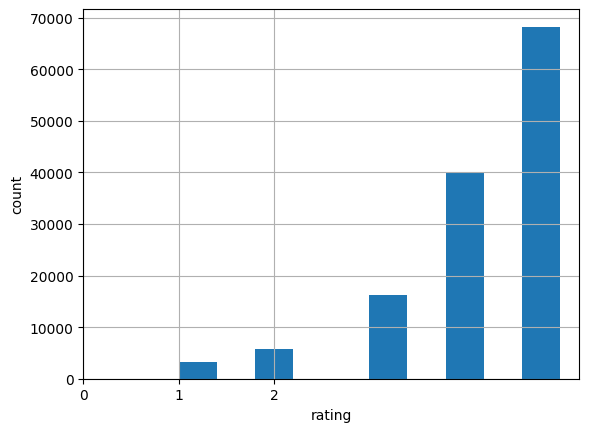

In [23]:
# preview column values of rating
print('number of data points:')
df.shape[0]

print('number of users:')
df.customer_id.nunique()

print('number of products:')
df.product_id.nunique()
print('')

_ = df.star_rating.hist()
_ = plt.xlabel("rating")
_ = plt.ylabel('count')
_ = plt.xticks([0,1,2])
plt.show()


plt.show()

## Model : collaborative filtering - model-based 
### SVD

In [26]:
print('user-item interaction matrix sparsity:')
print('%.4f' % (df.shape[0]/ (df.customer_id.nunique()*df.product_id.nunique())),'of the matrix contains rating data')

user-item interaction matrix sparsity:
0.0042 of the matrix contains rating data


In [27]:
# train test split
lst = list(df.index)
idx_train, idx_test, idx_train, idx_test = train_test_split(lst,lst,test_size=0.2, random_state=42)

In [36]:
trainset = df[df.index.isin(idx_train)]
testset = df[df.index.isin(idx_test)]

In [37]:
# Surprise pkg reader for train data
reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(trainset, reader)
train_set = data_train.build_full_trainset() # use the whole training set 

### Grid search: hyper-parameter search
#### Here we search for the best hyperparameter set using train/test split, instead of setting aside a separate val set, due to the small data size.

In [ ]:
df.customer_id.nunique()
df.product_id.nunique()
df.star_rating.value_counts()

In [39]:
n_fac = np.arange(2,100,8) 
lr = np.arange(0.001,0.01,0.001) 
reg = [0.01,0.02,0.04,0.08,0.1,0.2,0.4,0.8,1,2,4,10]

Y_pred_train = []
Y_pred_test = []

for n in n_fac:
    for l in lr:
        for r in reg:
            print('nfactor, lr, reg:',n,l,r,'\n')
            Y_pred_train = []
            Y_pred_test = []
            
            model = SVD(n_factors=n, lr_all=l, reg_all=r)
            model.fit(train_set)
            
            #predict train set with model
            for i in range(trainset.shape[0]):
                pred = model.predict(trainset.customer_id.iloc[i], trainset.product_id.iloc[i])
                Y_pred_train.append(pred.est)

            rms = mean_squared_error(list(trainset.star_rating), list(Y_pred_train), squared=False)
            ma = mean_absolute_error(list(trainset.star_rating), list(Y_pred_train))
            print('train RMSE,MAE:',"{:.3f}".format(rms),"{:.3f}".format(ma))

            #predict test set with model    
            for i in range(testset.shape[0]):
                pred = model.predict(testset.customer_id.iloc[i], testset.product_id.iloc[i])
                Y_pred_test.append(pred.est)
                
            rms = mean_squared_error(list(testset.star_rating), list(Y_pred_test), squared=False)
            ma = mean_absolute_error(list(testset.star_rating), list(Y_pred_test))
            print('test RMSE,MAE:',"{:.3f}".format(rms),"{:.3f}".format(ma),'\n\n')            

nfactor, lr, reg: 2 0.001 0.01 



train RMSE,MAE: 0.859 0.656
test RMSE,MAE: 0.885 0.676 


nfactor, lr, reg: 2 0.001 0.02 



train RMSE,MAE: 0.859 0.657
test RMSE,MAE: 0.885 0.676 


nfactor, lr, reg: 2 0.001 0.04 



train RMSE,MAE: 0.860 0.658
test RMSE,MAE: 0.885 0.677 


nfactor, lr, reg: 2 0.001 0.08 



train RMSE,MAE: 0.860 0.660
test RMSE,MAE: 0.886 0.679 


nfactor, lr, reg: 2 0.001 0.1 



train RMSE,MAE: 0.861 0.661
test RMSE,MAE: 0.886 0.680 


nfactor, lr, reg: 2 0.001 0.2 



train RMSE,MAE: 0.863 0.665
test RMSE,MAE: 0.888 0.684 


nfactor, lr, reg: 2 0.001 0.4 



train RMSE,MAE: 0.869 0.674
test RMSE,MAE: 0.892 0.691 


nfactor, lr, reg: 2 0.001 0.8 



train RMSE,MAE: 0.880 0.687
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 2 0.001 1 



train RMSE,MAE: 0.885 0.692
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 2 0.001 2 



train RMSE,MAE: 0.905 0.712
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 2 0.001 4 



train RMSE,MAE: 0.927 0.734
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 2 0.001 10 



train RMSE,MAE: 0.952 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 2 0.002 0.01 



train RMSE,MAE: 0.831 0.629
test RMSE,MAE: 0.872 0.661 


nfactor, lr, reg: 2 0.002 0.02 



train RMSE,MAE: 0.831 0.630
test RMSE,MAE: 0.872 0.661 


nfactor, lr, reg: 2 0.002 0.04 



train RMSE,MAE: 0.831 0.631
test RMSE,MAE: 0.873 0.663 


nfactor, lr, reg: 2 0.002 0.08 



train RMSE,MAE: 0.832 0.634
test RMSE,MAE: 0.873 0.665 


nfactor, lr, reg: 2 0.002 0.1 



train RMSE,MAE: 0.833 0.635
test RMSE,MAE: 0.873 0.666 


nfactor, lr, reg: 2 0.002 0.2 



train RMSE,MAE: 0.836 0.641
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 2 0.002 0.4 



train RMSE,MAE: 0.843 0.652
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 2 0.002 0.8 



train RMSE,MAE: 0.857 0.668
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 2 0.002 1 



train RMSE,MAE: 0.863 0.675
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 2 0.002 2 



train RMSE,MAE: 0.888 0.698
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 2 0.002 4 



train RMSE,MAE: 0.915 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 2 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 2 0.003 0.01 



train RMSE,MAE: 0.811 0.612
test RMSE,MAE: 0.867 0.654 


nfactor, lr, reg: 2 0.003 0.02 



train RMSE,MAE: 0.812 0.613
test RMSE,MAE: 0.867 0.654 


nfactor, lr, reg: 2 0.003 0.04 



train RMSE,MAE: 0.812 0.614
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 2 0.003 0.08 



train RMSE,MAE: 0.813 0.617
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 2 0.003 0.1 



train RMSE,MAE: 0.814 0.619
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 2 0.003 0.2 



train RMSE,MAE: 0.818 0.626
test RMSE,MAE: 0.869 0.665 


nfactor, lr, reg: 2 0.003 0.4 



train RMSE,MAE: 0.826 0.638
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 2 0.003 0.8 



train RMSE,MAE: 0.842 0.656
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 2 0.003 1 



train RMSE,MAE: 0.849 0.663
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 2 0.003 2 



train RMSE,MAE: 0.877 0.689
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 2 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 2 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 2 0.004 0.01 



train RMSE,MAE: 0.796 0.599
test RMSE,MAE: 0.863 0.650 


nfactor, lr, reg: 2 0.004 0.02 



train RMSE,MAE: 0.796 0.600
test RMSE,MAE: 0.863 0.650 


nfactor, lr, reg: 2 0.004 0.04 



train RMSE,MAE: 0.797 0.601
test RMSE,MAE: 0.863 0.651 


nfactor, lr, reg: 2 0.004 0.08 



train RMSE,MAE: 0.799 0.605
test RMSE,MAE: 0.864 0.654 


nfactor, lr, reg: 2 0.004 0.1 



train RMSE,MAE: 0.800 0.606
test RMSE,MAE: 0.864 0.655 


nfactor, lr, reg: 2 0.004 0.2 



train RMSE,MAE: 0.804 0.614
test RMSE,MAE: 0.865 0.661 


nfactor, lr, reg: 2 0.004 0.4 



train RMSE,MAE: 0.813 0.627
test RMSE,MAE: 0.871 0.671 


nfactor, lr, reg: 2 0.004 0.8 



train RMSE,MAE: 0.831 0.647
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 2 0.004 1 



train RMSE,MAE: 0.839 0.655
test RMSE,MAE: 0.890 0.693 


nfactor, lr, reg: 2 0.004 2 



train RMSE,MAE: 0.869 0.683
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 2 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.936 0.737 


nfactor, lr, reg: 2 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 2 0.005 0.01 



train RMSE,MAE: 0.783 0.587
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 2 0.005 0.02 



train RMSE,MAE: 0.783 0.588
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 2 0.005 0.04 



train RMSE,MAE: 0.784 0.590
test RMSE,MAE: 0.861 0.649 


nfactor, lr, reg: 2 0.005 0.08 



train RMSE,MAE: 0.787 0.594
test RMSE,MAE: 0.861 0.651 


nfactor, lr, reg: 2 0.005 0.1 



train RMSE,MAE: 0.788 0.596
test RMSE,MAE: 0.862 0.652 


nfactor, lr, reg: 2 0.005 0.2 



train RMSE,MAE: 0.793 0.604
test RMSE,MAE: 0.863 0.658 


nfactor, lr, reg: 2 0.005 0.4 



train RMSE,MAE: 0.803 0.618
test RMSE,MAE: 0.869 0.669 


nfactor, lr, reg: 2 0.005 0.8 



train RMSE,MAE: 0.822 0.639
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 2 0.005 1 



train RMSE,MAE: 0.830 0.648
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 2 0.005 2 



train RMSE,MAE: 0.863 0.678
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 2 0.005 4 



train RMSE,MAE: 0.900 0.711
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 2 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 2 0.006 0.01 



train RMSE,MAE: 0.769 0.577
test RMSE,MAE: 0.860 0.645 


nfactor, lr, reg: 2 0.006 0.02 



train RMSE,MAE: 0.771 0.579
test RMSE,MAE: 0.859 0.645 


nfactor, lr, reg: 2 0.006 0.04 



train RMSE,MAE: 0.773 0.581
test RMSE,MAE: 0.860 0.647 


nfactor, lr, reg: 2 0.006 0.08 



train RMSE,MAE: 0.776 0.586
test RMSE,MAE: 0.860 0.649 


nfactor, lr, reg: 2 0.006 0.1 



train RMSE,MAE: 0.778 0.588
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 2 0.006 0.2 



train RMSE,MAE: 0.783 0.596
test RMSE,MAE: 0.862 0.656 


nfactor, lr, reg: 2 0.006 0.4 



train RMSE,MAE: 0.794 0.611
test RMSE,MAE: 0.868 0.667 


nfactor, lr, reg: 2 0.006 0.8 



train RMSE,MAE: 0.814 0.633
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 2 0.006 1 



train RMSE,MAE: 0.824 0.642
test RMSE,MAE: 0.887 0.691 


nfactor, lr, reg: 2 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 2 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 2 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 2 0.007 0.01 



train RMSE,MAE: 0.758 0.567
test RMSE,MAE: 0.860 0.644 


nfactor, lr, reg: 2 0.007 0.02 



train RMSE,MAE: 0.761 0.570
test RMSE,MAE: 0.860 0.644 


nfactor, lr, reg: 2 0.007 0.04 



train RMSE,MAE: 0.764 0.573
test RMSE,MAE: 0.859 0.645 


nfactor, lr, reg: 2 0.007 0.08 



train RMSE,MAE: 0.767 0.578
test RMSE,MAE: 0.859 0.647 


nfactor, lr, reg: 2 0.007 0.1 



train RMSE,MAE: 0.769 0.580
test RMSE,MAE: 0.859 0.649 


nfactor, lr, reg: 2 0.007 0.2 



train RMSE,MAE: 0.775 0.589
test RMSE,MAE: 0.861 0.655 


nfactor, lr, reg: 2 0.007 0.4 



train RMSE,MAE: 0.787 0.605
test RMSE,MAE: 0.867 0.666 


nfactor, lr, reg: 2 0.007 0.8 



train RMSE,MAE: 0.808 0.628
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 2 0.007 1 



train RMSE,MAE: 0.818 0.638
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 2 0.007 2 



train RMSE,MAE: 0.855 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 2 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 2 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 2 0.008 0.01 



train RMSE,MAE: 0.748 0.559
test RMSE,MAE: 0.860 0.643 


nfactor, lr, reg: 2 0.008 0.02 



train RMSE,MAE: 0.751 0.562
test RMSE,MAE: 0.859 0.643 


nfactor, lr, reg: 2 0.008 0.04 



train RMSE,MAE: 0.753 0.564
test RMSE,MAE: 0.858 0.644 


nfactor, lr, reg: 2 0.008 0.08 



train RMSE,MAE: 0.759 0.571
test RMSE,MAE: 0.859 0.646 


nfactor, lr, reg: 2 0.008 0.1 



train RMSE,MAE: 0.761 0.573
test RMSE,MAE: 0.859 0.647 


nfactor, lr, reg: 2 0.008 0.2 



train RMSE,MAE: 0.768 0.583
test RMSE,MAE: 0.861 0.654 


nfactor, lr, reg: 2 0.008 0.4 



train RMSE,MAE: 0.781 0.599
test RMSE,MAE: 0.867 0.665 


nfactor, lr, reg: 2 0.008 0.8 



train RMSE,MAE: 0.804 0.624
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 2 0.008 1 



train RMSE,MAE: 0.814 0.634
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 2 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 2 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 2 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 2 0.009000000000000001 0.01 



train RMSE,MAE: 0.733 0.548
test RMSE,MAE: 0.858 0.641 


nfactor, lr, reg: 2 0.009000000000000001 0.02 



train RMSE,MAE: 0.737 0.552
test RMSE,MAE: 0.859 0.642 


nfactor, lr, reg: 2 0.009000000000000001 0.04 



train RMSE,MAE: 0.745 0.558
test RMSE,MAE: 0.858 0.643 


nfactor, lr, reg: 2 0.009000000000000001 0.08 



train RMSE,MAE: 0.751 0.565
test RMSE,MAE: 0.859 0.646 


nfactor, lr, reg: 2 0.009000000000000001 0.1 



train RMSE,MAE: 0.754 0.568
test RMSE,MAE: 0.859 0.647 


nfactor, lr, reg: 2 0.009000000000000001 0.2 



train RMSE,MAE: 0.762 0.578
test RMSE,MAE: 0.861 0.653 


nfactor, lr, reg: 2 0.009000000000000001 0.4 



train RMSE,MAE: 0.776 0.595
test RMSE,MAE: 0.867 0.664 


nfactor, lr, reg: 2 0.009000000000000001 0.8 



train RMSE,MAE: 0.799 0.621
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 2 0.009000000000000001 1 



train RMSE,MAE: 0.810 0.631
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 2 0.009000000000000001 2 



train RMSE,MAE: 0.850 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 2 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 2 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 10 0.001 0.01 



train RMSE,MAE: 0.857 0.654
test RMSE,MAE: 0.885 0.676 


nfactor, lr, reg: 10 0.001 0.02 



train RMSE,MAE: 0.857 0.655
test RMSE,MAE: 0.885 0.676 


nfactor, lr, reg: 10 0.001 0.04 



train RMSE,MAE: 0.857 0.656
test RMSE,MAE: 0.886 0.677 


nfactor, lr, reg: 10 0.001 0.08 



train RMSE,MAE: 0.858 0.658
test RMSE,MAE: 0.886 0.679 


nfactor, lr, reg: 10 0.001 0.1 



train RMSE,MAE: 0.859 0.659
test RMSE,MAE: 0.886 0.680 


nfactor, lr, reg: 10 0.001 0.2 



train RMSE,MAE: 0.861 0.664
test RMSE,MAE: 0.888 0.684 


nfactor, lr, reg: 10 0.001 0.4 



train RMSE,MAE: 0.867 0.673
test RMSE,MAE: 0.892 0.691 


nfactor, lr, reg: 10 0.001 0.8 



train RMSE,MAE: 0.879 0.686
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 10 0.001 1 



train RMSE,MAE: 0.884 0.692
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 10 0.001 2 



train RMSE,MAE: 0.904 0.712
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 10 0.001 4 



train RMSE,MAE: 0.927 0.734
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 10 0.001 10 



train RMSE,MAE: 0.952 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 10 0.002 0.01 



train RMSE,MAE: 0.825 0.625
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 10 0.002 0.02 



train RMSE,MAE: 0.825 0.626
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 10 0.002 0.04 



train RMSE,MAE: 0.827 0.628
test RMSE,MAE: 0.873 0.663 


nfactor, lr, reg: 10 0.002 0.08 



train RMSE,MAE: 0.828 0.631
test RMSE,MAE: 0.873 0.665 


nfactor, lr, reg: 10 0.002 0.1 



train RMSE,MAE: 0.829 0.632
test RMSE,MAE: 0.873 0.666 


nfactor, lr, reg: 10 0.002 0.2 



train RMSE,MAE: 0.833 0.639
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 10 0.002 0.4 



train RMSE,MAE: 0.841 0.650
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 10 0.002 0.8 



train RMSE,MAE: 0.856 0.667
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 10 0.002 1 



train RMSE,MAE: 0.862 0.674
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 10 0.002 2 



train RMSE,MAE: 0.887 0.698
test RMSE,MAE: 0.917 0.720 


nfactor, lr, reg: 10 0.002 4 



train RMSE,MAE: 0.915 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 10 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 10 0.003 0.01 



train RMSE,MAE: 0.802 0.605
test RMSE,MAE: 0.867 0.654 


nfactor, lr, reg: 10 0.003 0.02 



train RMSE,MAE: 0.803 0.607
test RMSE,MAE: 0.867 0.655 


nfactor, lr, reg: 10 0.003 0.04 



train RMSE,MAE: 0.805 0.609
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 10 0.003 0.08 



train RMSE,MAE: 0.808 0.613
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 10 0.003 0.1 



train RMSE,MAE: 0.809 0.615
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 10 0.003 0.2 



train RMSE,MAE: 0.814 0.623
test RMSE,MAE: 0.869 0.665 


nfactor, lr, reg: 10 0.003 0.4 



train RMSE,MAE: 0.824 0.636
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 10 0.003 0.8 



train RMSE,MAE: 0.841 0.655
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 10 0.003 1 



train RMSE,MAE: 0.849 0.663
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 10 0.003 2 



train RMSE,MAE: 0.877 0.689
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 10 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 10 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 10 0.004 0.01 



train RMSE,MAE: 0.782 0.589
test RMSE,MAE: 0.863 0.650 


nfactor, lr, reg: 10 0.004 0.02 



train RMSE,MAE: 0.784 0.591
test RMSE,MAE: 0.863 0.650 


nfactor, lr, reg: 10 0.004 0.04 



train RMSE,MAE: 0.787 0.594
test RMSE,MAE: 0.863 0.651 


nfactor, lr, reg: 10 0.004 0.08 



train RMSE,MAE: 0.791 0.599
test RMSE,MAE: 0.863 0.654 


nfactor, lr, reg: 10 0.004 0.1 



train RMSE,MAE: 0.793 0.601
test RMSE,MAE: 0.863 0.655 


nfactor, lr, reg: 10 0.004 0.2 



train RMSE,MAE: 0.800 0.611
test RMSE,MAE: 0.865 0.661 


nfactor, lr, reg: 10 0.004 0.4 



train RMSE,MAE: 0.811 0.625
test RMSE,MAE: 0.871 0.671 


nfactor, lr, reg: 10 0.004 0.8 



train RMSE,MAE: 0.830 0.646
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 10 0.004 1 



train RMSE,MAE: 0.838 0.654
test RMSE,MAE: 0.890 0.693 


nfactor, lr, reg: 10 0.004 2 



train RMSE,MAE: 0.869 0.683
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 10 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 10 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 10 0.005 0.01 



train RMSE,MAE: 0.763 0.573
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 10 0.005 0.02 



train RMSE,MAE: 0.766 0.577
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 10 0.005 0.04 



train RMSE,MAE: 0.770 0.581
test RMSE,MAE: 0.860 0.648 


nfactor, lr, reg: 10 0.005 0.08 



train RMSE,MAE: 0.777 0.587
test RMSE,MAE: 0.861 0.651 


nfactor, lr, reg: 10 0.005 0.1 



train RMSE,MAE: 0.779 0.590
test RMSE,MAE: 0.861 0.652 


nfactor, lr, reg: 10 0.005 0.2 



train RMSE,MAE: 0.788 0.601
test RMSE,MAE: 0.863 0.658 


nfactor, lr, reg: 10 0.005 0.4 



train RMSE,MAE: 0.801 0.617
test RMSE,MAE: 0.869 0.669 


nfactor, lr, reg: 10 0.005 0.8 



train RMSE,MAE: 0.821 0.639
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 10 0.005 1 



train RMSE,MAE: 0.830 0.648
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 10 0.005 2 



train RMSE,MAE: 0.863 0.678
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 10 0.005 4 



train RMSE,MAE: 0.900 0.711
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 10 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 10 0.006 0.01 



train RMSE,MAE: 0.742 0.557
test RMSE,MAE: 0.860 0.645 


nfactor, lr, reg: 10 0.006 0.02 



train RMSE,MAE: 0.747 0.562
test RMSE,MAE: 0.859 0.644 


nfactor, lr, reg: 10 0.006 0.04 



train RMSE,MAE: 0.754 0.568
test RMSE,MAE: 0.859 0.646 


nfactor, lr, reg: 10 0.006 0.08 



train RMSE,MAE: 0.764 0.577
test RMSE,MAE: 0.860 0.649 


nfactor, lr, reg: 10 0.006 0.1 



train RMSE,MAE: 0.767 0.580
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 10 0.006 0.2 



train RMSE,MAE: 0.778 0.593
test RMSE,MAE: 0.862 0.656 


nfactor, lr, reg: 10 0.006 0.4 



train RMSE,MAE: 0.792 0.609
test RMSE,MAE: 0.868 0.667 


nfactor, lr, reg: 10 0.006 0.8 



train RMSE,MAE: 0.814 0.633
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 10 0.006 1 



train RMSE,MAE: 0.823 0.642
test RMSE,MAE: 0.887 0.691 


nfactor, lr, reg: 10 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 10 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 10 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 10 0.007 0.01 



train RMSE,MAE: 0.719 0.540
test RMSE,MAE: 0.860 0.643 


nfactor, lr, reg: 10 0.007 0.02 



train RMSE,MAE: 0.728 0.547
test RMSE,MAE: 0.859 0.643 


nfactor, lr, reg: 10 0.007 0.04 



train RMSE,MAE: 0.739 0.556
test RMSE,MAE: 0.858 0.643 


nfactor, lr, reg: 10 0.007 0.08 



train RMSE,MAE: 0.751 0.567
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 10 0.007 0.1 



train RMSE,MAE: 0.756 0.571
test RMSE,MAE: 0.858 0.648 


nfactor, lr, reg: 10 0.007 0.2 



train RMSE,MAE: 0.769 0.585
test RMSE,MAE: 0.861 0.654 


nfactor, lr, reg: 10 0.007 0.4 



train RMSE,MAE: 0.785 0.603
test RMSE,MAE: 0.867 0.666 


nfactor, lr, reg: 10 0.007 0.8 



train RMSE,MAE: 0.808 0.628
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 10 0.007 1 



train RMSE,MAE: 0.818 0.638
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 10 0.007 2 



train RMSE,MAE: 0.855 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 10 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 10 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 10 0.008 0.01 



train RMSE,MAE: 0.696 0.522
test RMSE,MAE: 0.860 0.642 


nfactor, lr, reg: 10 0.008 0.02 



train RMSE,MAE: 0.704 0.529
test RMSE,MAE: 0.858 0.642 


nfactor, lr, reg: 10 0.008 0.04 



train RMSE,MAE: 0.721 0.543
test RMSE,MAE: 0.858 0.644 


nfactor, lr, reg: 10 0.008 0.08 



train RMSE,MAE: 0.740 0.558
test RMSE,MAE: 0.858 0.646 


nfactor, lr, reg: 10 0.008 0.1 



train RMSE,MAE: 0.746 0.563
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 10 0.008 0.2 



train RMSE,MAE: 0.762 0.579
test RMSE,MAE: 0.860 0.653 


nfactor, lr, reg: 10 0.008 0.4 



train RMSE,MAE: 0.779 0.598
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 10 0.008 0.8 



train RMSE,MAE: 0.803 0.624
test RMSE,MAE: 0.880 0.682 


nfactor, lr, reg: 10 0.008 1 



train RMSE,MAE: 0.813 0.634
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 10 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 10 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 10 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 10 0.009000000000000001 0.01 



train RMSE,MAE: 0.665 0.499
test RMSE,MAE: 0.861 0.642 


nfactor, lr, reg: 10 0.009000000000000001 0.02 



train RMSE,MAE: 0.682 0.512
test RMSE,MAE: 0.859 0.642 


nfactor, lr, reg: 10 0.009000000000000001 0.04 



train RMSE,MAE: 0.702 0.529
test RMSE,MAE: 0.858 0.642 


nfactor, lr, reg: 10 0.009000000000000001 0.08 



train RMSE,MAE: 0.728 0.549
test RMSE,MAE: 0.858 0.645 


nfactor, lr, reg: 10 0.009000000000000001 0.1 



train RMSE,MAE: 0.734 0.554
test RMSE,MAE: 0.857 0.645 


nfactor, lr, reg: 10 0.009000000000000001 0.2 



train RMSE,MAE: 0.755 0.573
test RMSE,MAE: 0.860 0.652 


nfactor, lr, reg: 10 0.009000000000000001 0.4 



train RMSE,MAE: 0.774 0.593
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 10 0.009000000000000001 0.8 



train RMSE,MAE: 0.799 0.620
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 10 0.009000000000000001 1 



train RMSE,MAE: 0.810 0.631
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 10 0.009000000000000001 2 



train RMSE,MAE: 0.850 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 10 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 10 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 18 0.001 0.01 



train RMSE,MAE: 0.854 0.652
test RMSE,MAE: 0.886 0.676 


nfactor, lr, reg: 18 0.001 0.02 



train RMSE,MAE: 0.854 0.653
test RMSE,MAE: 0.885 0.677 


nfactor, lr, reg: 18 0.001 0.04 



train RMSE,MAE: 0.855 0.654
test RMSE,MAE: 0.886 0.677 


nfactor, lr, reg: 18 0.001 0.08 



train RMSE,MAE: 0.856 0.656
test RMSE,MAE: 0.886 0.679 


nfactor, lr, reg: 18 0.001 0.1 



train RMSE,MAE: 0.857 0.657
test RMSE,MAE: 0.886 0.680 


nfactor, lr, reg: 18 0.001 0.2 



train RMSE,MAE: 0.860 0.663
test RMSE,MAE: 0.888 0.684 


nfactor, lr, reg: 18 0.001 0.4 



train RMSE,MAE: 0.866 0.672
test RMSE,MAE: 0.892 0.691 


nfactor, lr, reg: 18 0.001 0.8 



train RMSE,MAE: 0.878 0.686
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 18 0.001 1 



train RMSE,MAE: 0.883 0.691
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 18 0.001 2 



train RMSE,MAE: 0.904 0.712
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 18 0.001 4 



train RMSE,MAE: 0.927 0.734
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 18 0.001 10 



train RMSE,MAE: 0.952 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 18 0.002 0.01 



train RMSE,MAE: 0.820 0.621
test RMSE,MAE: 0.873 0.661 


nfactor, lr, reg: 18 0.002 0.02 



train RMSE,MAE: 0.821 0.622
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 18 0.002 0.04 



train RMSE,MAE: 0.822 0.625
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 18 0.002 0.08 



train RMSE,MAE: 0.824 0.628
test RMSE,MAE: 0.873 0.665 


nfactor, lr, reg: 18 0.002 0.1 



train RMSE,MAE: 0.825 0.630
test RMSE,MAE: 0.873 0.666 


nfactor, lr, reg: 18 0.002 0.2 



train RMSE,MAE: 0.830 0.637
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 18 0.002 0.4 



train RMSE,MAE: 0.839 0.649
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 18 0.002 0.8 



train RMSE,MAE: 0.855 0.667
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 18 0.002 1 



train RMSE,MAE: 0.862 0.674
test RMSE,MAE: 0.897 0.699 


nfactor, lr, reg: 18 0.002 2 



train RMSE,MAE: 0.887 0.698
test RMSE,MAE: 0.917 0.720 


nfactor, lr, reg: 18 0.002 4 



train RMSE,MAE: 0.915 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 18 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 18 0.003 0.01 



train RMSE,MAE: 0.794 0.599
test RMSE,MAE: 0.867 0.654 


nfactor, lr, reg: 18 0.003 0.02 



train RMSE,MAE: 0.796 0.601
test RMSE,MAE: 0.867 0.655 


nfactor, lr, reg: 18 0.003 0.04 



train RMSE,MAE: 0.798 0.604
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 18 0.003 0.08 



train RMSE,MAE: 0.802 0.609
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 18 0.003 0.1 



train RMSE,MAE: 0.804 0.611
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 18 0.003 0.2 



train RMSE,MAE: 0.811 0.621
test RMSE,MAE: 0.869 0.665 


nfactor, lr, reg: 18 0.003 0.4 



train RMSE,MAE: 0.822 0.635
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 18 0.003 0.8 



train RMSE,MAE: 0.840 0.655
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 18 0.003 1 



train RMSE,MAE: 0.848 0.662
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 18 0.003 2 



train RMSE,MAE: 0.876 0.689
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 18 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 18 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 18 0.004 0.01 



train RMSE,MAE: 0.770 0.580
test RMSE,MAE: 0.864 0.651 


nfactor, lr, reg: 18 0.004 0.02 



train RMSE,MAE: 0.773 0.583
test RMSE,MAE: 0.864 0.651 


nfactor, lr, reg: 18 0.004 0.04 



train RMSE,MAE: 0.777 0.587
test RMSE,MAE: 0.863 0.651 


nfactor, lr, reg: 18 0.004 0.08 



train RMSE,MAE: 0.784 0.594
test RMSE,MAE: 0.863 0.653 


nfactor, lr, reg: 18 0.004 0.1 



train RMSE,MAE: 0.786 0.597
test RMSE,MAE: 0.863 0.655 


nfactor, lr, reg: 18 0.004 0.2 



train RMSE,MAE: 0.796 0.608
test RMSE,MAE: 0.865 0.660 


nfactor, lr, reg: 18 0.004 0.4 



train RMSE,MAE: 0.809 0.624
test RMSE,MAE: 0.871 0.671 


nfactor, lr, reg: 18 0.004 0.8 



train RMSE,MAE: 0.829 0.646
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 18 0.004 1 



train RMSE,MAE: 0.838 0.654
test RMSE,MAE: 0.890 0.693 


nfactor, lr, reg: 18 0.004 2 



train RMSE,MAE: 0.869 0.683
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 18 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.936 0.737 


nfactor, lr, reg: 18 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 18 0.005 0.01 



train RMSE,MAE: 0.745 0.561
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 18 0.005 0.02 



train RMSE,MAE: 0.749 0.565
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 18 0.005 0.04 



train RMSE,MAE: 0.757 0.571
test RMSE,MAE: 0.861 0.649 


nfactor, lr, reg: 18 0.005 0.08 



train RMSE,MAE: 0.767 0.581
test RMSE,MAE: 0.861 0.651 


nfactor, lr, reg: 18 0.005 0.1 



train RMSE,MAE: 0.771 0.585
test RMSE,MAE: 0.861 0.652 


nfactor, lr, reg: 18 0.005 0.2 



train RMSE,MAE: 0.784 0.598
test RMSE,MAE: 0.863 0.658 


nfactor, lr, reg: 18 0.005 0.4 



train RMSE,MAE: 0.799 0.616
test RMSE,MAE: 0.869 0.669 


nfactor, lr, reg: 18 0.005 0.8 



train RMSE,MAE: 0.820 0.639
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 18 0.005 1 



train RMSE,MAE: 0.829 0.647
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 18 0.005 2 



train RMSE,MAE: 0.863 0.678
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 18 0.005 4 



train RMSE,MAE: 0.899 0.711
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 18 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 18 0.006 0.01 



train RMSE,MAE: 0.716 0.539
test RMSE,MAE: 0.861 0.645 


nfactor, lr, reg: 18 0.006 0.02 



train RMSE,MAE: 0.727 0.547
test RMSE,MAE: 0.860 0.645 


nfactor, lr, reg: 18 0.006 0.04 



train RMSE,MAE: 0.737 0.556
test RMSE,MAE: 0.859 0.646 


nfactor, lr, reg: 18 0.006 0.08 



train RMSE,MAE: 0.752 0.569
test RMSE,MAE: 0.859 0.648 


nfactor, lr, reg: 18 0.006 0.1 



train RMSE,MAE: 0.757 0.573
test RMSE,MAE: 0.859 0.650 


nfactor, lr, reg: 18 0.006 0.2 



train RMSE,MAE: 0.773 0.589
test RMSE,MAE: 0.861 0.656 


nfactor, lr, reg: 18 0.006 0.4 



train RMSE,MAE: 0.790 0.608
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 18 0.006 0.8 



train RMSE,MAE: 0.813 0.633
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 18 0.006 1 



train RMSE,MAE: 0.823 0.642
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 18 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 18 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 18 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 18 0.007 0.01 



train RMSE,MAE: 0.687 0.516
test RMSE,MAE: 0.858 0.643 


nfactor, lr, reg: 18 0.007 0.02 



train RMSE,MAE: 0.698 0.525
test RMSE,MAE: 0.859 0.643 


nfactor, lr, reg: 18 0.007 0.04 



train RMSE,MAE: 0.716 0.540
test RMSE,MAE: 0.858 0.644 


nfactor, lr, reg: 18 0.007 0.08 



train RMSE,MAE: 0.737 0.557
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 18 0.007 0.1 



train RMSE,MAE: 0.743 0.563
test RMSE,MAE: 0.858 0.648 


nfactor, lr, reg: 18 0.007 0.2 



train RMSE,MAE: 0.764 0.582
test RMSE,MAE: 0.861 0.654 


nfactor, lr, reg: 18 0.007 0.4 



train RMSE,MAE: 0.783 0.602
test RMSE,MAE: 0.867 0.666 


nfactor, lr, reg: 18 0.007 0.8 



train RMSE,MAE: 0.808 0.628
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 18 0.007 1 



train RMSE,MAE: 0.817 0.637
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 18 0.007 2 



train RMSE,MAE: 0.855 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 18 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 18 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 18 0.008 0.01 



train RMSE,MAE: 0.655 0.492
test RMSE,MAE: 0.861 0.642 


nfactor, lr, reg: 18 0.008 0.02 



train RMSE,MAE: 0.670 0.504
test RMSE,MAE: 0.859 0.642 


nfactor, lr, reg: 18 0.008 0.04 



train RMSE,MAE: 0.694 0.524
test RMSE,MAE: 0.857 0.643 


nfactor, lr, reg: 18 0.008 0.08 



train RMSE,MAE: 0.722 0.546
test RMSE,MAE: 0.857 0.645 


nfactor, lr, reg: 18 0.008 0.1 



train RMSE,MAE: 0.731 0.553
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 18 0.008 0.2 



train RMSE,MAE: 0.756 0.575
test RMSE,MAE: 0.860 0.653 


nfactor, lr, reg: 18 0.008 0.4 



train RMSE,MAE: 0.777 0.597
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 18 0.008 0.8 



train RMSE,MAE: 0.803 0.624
test RMSE,MAE: 0.880 0.682 


nfactor, lr, reg: 18 0.008 1 



train RMSE,MAE: 0.813 0.634
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 18 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 18 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 18 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 18 0.009000000000000001 0.01 



train RMSE,MAE: 0.621 0.466
test RMSE,MAE: 0.861 0.641 


nfactor, lr, reg: 18 0.009000000000000001 0.02 



train RMSE,MAE: 0.642 0.484
test RMSE,MAE: 0.858 0.640 


nfactor, lr, reg: 18 0.009000000000000001 0.04 



train RMSE,MAE: 0.669 0.505
test RMSE,MAE: 0.857 0.641 


nfactor, lr, reg: 18 0.009000000000000001 0.08 



train RMSE,MAE: 0.707 0.535
test RMSE,MAE: 0.857 0.644 


nfactor, lr, reg: 18 0.009000000000000001 0.1 



train RMSE,MAE: 0.718 0.543
test RMSE,MAE: 0.857 0.645 


nfactor, lr, reg: 18 0.009000000000000001 0.2 



train RMSE,MAE: 0.748 0.568
test RMSE,MAE: 0.860 0.652 


nfactor, lr, reg: 18 0.009000000000000001 0.4 



train RMSE,MAE: 0.772 0.592
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 18 0.009000000000000001 0.8 



train RMSE,MAE: 0.799 0.620
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 18 0.009000000000000001 1 



train RMSE,MAE: 0.809 0.630
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 18 0.009000000000000001 2 



train RMSE,MAE: 0.850 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 18 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 18 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 26 0.001 0.01 



train RMSE,MAE: 0.852 0.651
test RMSE,MAE: 0.885 0.676 


nfactor, lr, reg: 26 0.001 0.02 



train RMSE,MAE: 0.852 0.651
test RMSE,MAE: 0.886 0.677 


nfactor, lr, reg: 26 0.001 0.04 



train RMSE,MAE: 0.853 0.652
test RMSE,MAE: 0.886 0.678 


nfactor, lr, reg: 26 0.001 0.08 



train RMSE,MAE: 0.854 0.655
test RMSE,MAE: 0.887 0.679 


nfactor, lr, reg: 26 0.001 0.1 



train RMSE,MAE: 0.855 0.656
test RMSE,MAE: 0.886 0.680 


nfactor, lr, reg: 26 0.001 0.2 



train RMSE,MAE: 0.858 0.661
test RMSE,MAE: 0.888 0.684 


nfactor, lr, reg: 26 0.001 0.4 



train RMSE,MAE: 0.865 0.671
test RMSE,MAE: 0.893 0.691 


nfactor, lr, reg: 26 0.001 0.8 



train RMSE,MAE: 0.877 0.685
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 26 0.001 1 



train RMSE,MAE: 0.883 0.691
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 26 0.001 2 



train RMSE,MAE: 0.904 0.711
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 26 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 26 0.001 10 



train RMSE,MAE: 0.952 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 26 0.002 0.01 



train RMSE,MAE: 0.815 0.618
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 26 0.002 0.02 



train RMSE,MAE: 0.816 0.619
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 26 0.002 0.04 



train RMSE,MAE: 0.817 0.621
test RMSE,MAE: 0.873 0.663 


nfactor, lr, reg: 26 0.002 0.08 



train RMSE,MAE: 0.820 0.625
test RMSE,MAE: 0.873 0.665 


nfactor, lr, reg: 26 0.002 0.1 



train RMSE,MAE: 0.822 0.627
test RMSE,MAE: 0.874 0.666 


nfactor, lr, reg: 26 0.002 0.2 



train RMSE,MAE: 0.828 0.635
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 26 0.002 0.4 



train RMSE,MAE: 0.838 0.648
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 26 0.002 0.8 



train RMSE,MAE: 0.854 0.666
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 26 0.002 1 



train RMSE,MAE: 0.861 0.673
test RMSE,MAE: 0.897 0.699 


nfactor, lr, reg: 26 0.002 2 



train RMSE,MAE: 0.887 0.698
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 26 0.002 4 



train RMSE,MAE: 0.915 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 26 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 26 0.003 0.01 



train RMSE,MAE: 0.786 0.593
test RMSE,MAE: 0.868 0.655 


nfactor, lr, reg: 26 0.003 0.02 



train RMSE,MAE: 0.788 0.595
test RMSE,MAE: 0.867 0.655 


nfactor, lr, reg: 26 0.003 0.04 



train RMSE,MAE: 0.791 0.599
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 26 0.003 0.08 



train RMSE,MAE: 0.797 0.605
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 26 0.003 0.1 



train RMSE,MAE: 0.799 0.608
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 26 0.003 0.2 



train RMSE,MAE: 0.808 0.618
test RMSE,MAE: 0.869 0.665 


nfactor, lr, reg: 26 0.003 0.4 



train RMSE,MAE: 0.820 0.634
test RMSE,MAE: 0.874 0.675 


nfactor, lr, reg: 26 0.003 0.8 



train RMSE,MAE: 0.840 0.654
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 26 0.003 1 



train RMSE,MAE: 0.847 0.662
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 26 0.003 2 



train RMSE,MAE: 0.876 0.689
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 26 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 26 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 26 0.004 0.01 



train RMSE,MAE: 0.757 0.571
test RMSE,MAE: 0.863 0.650 


nfactor, lr, reg: 26 0.004 0.02 



train RMSE,MAE: 0.762 0.574
test RMSE,MAE: 0.863 0.650 


nfactor, lr, reg: 26 0.004 0.04 



train RMSE,MAE: 0.768 0.580
test RMSE,MAE: 0.863 0.651 


nfactor, lr, reg: 26 0.004 0.08 



train RMSE,MAE: 0.777 0.589
test RMSE,MAE: 0.863 0.653 


nfactor, lr, reg: 26 0.004 0.1 



train RMSE,MAE: 0.780 0.593
test RMSE,MAE: 0.863 0.654 


nfactor, lr, reg: 26 0.004 0.2 



train RMSE,MAE: 0.792 0.606
test RMSE,MAE: 0.865 0.661 


nfactor, lr, reg: 26 0.004 0.4 



train RMSE,MAE: 0.807 0.623
test RMSE,MAE: 0.871 0.671 


nfactor, lr, reg: 26 0.004 0.8 



train RMSE,MAE: 0.829 0.645
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 26 0.004 1 



train RMSE,MAE: 0.837 0.654
test RMSE,MAE: 0.890 0.693 


nfactor, lr, reg: 26 0.004 2 



train RMSE,MAE: 0.868 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 26 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 26 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 26 0.005 0.01 



train RMSE,MAE: 0.728 0.548
test RMSE,MAE: 0.862 0.648 


nfactor, lr, reg: 26 0.005 0.02 



train RMSE,MAE: 0.733 0.553
test RMSE,MAE: 0.861 0.648 


nfactor, lr, reg: 26 0.005 0.04 



train RMSE,MAE: 0.744 0.562
test RMSE,MAE: 0.861 0.648 


nfactor, lr, reg: 26 0.005 0.08 



train RMSE,MAE: 0.758 0.574
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 26 0.005 0.1 



train RMSE,MAE: 0.763 0.579
test RMSE,MAE: 0.861 0.652 


nfactor, lr, reg: 26 0.005 0.2 



train RMSE,MAE: 0.779 0.595
test RMSE,MAE: 0.863 0.658 


nfactor, lr, reg: 26 0.005 0.4 



train RMSE,MAE: 0.797 0.614
test RMSE,MAE: 0.869 0.668 


nfactor, lr, reg: 26 0.005 0.8 



train RMSE,MAE: 0.820 0.638
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 26 0.005 1 



train RMSE,MAE: 0.829 0.647
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 26 0.005 2 



train RMSE,MAE: 0.863 0.678
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 26 0.005 4 



train RMSE,MAE: 0.899 0.711
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 26 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 26 0.006 0.01 



train RMSE,MAE: 0.692 0.521
test RMSE,MAE: 0.860 0.644 


nfactor, lr, reg: 26 0.006 0.02 



train RMSE,MAE: 0.706 0.532
test RMSE,MAE: 0.860 0.645 


nfactor, lr, reg: 26 0.006 0.04 



train RMSE,MAE: 0.720 0.544
test RMSE,MAE: 0.858 0.645 


nfactor, lr, reg: 26 0.006 0.08 



train RMSE,MAE: 0.742 0.562
test RMSE,MAE: 0.859 0.648 


nfactor, lr, reg: 26 0.006 0.1 



train RMSE,MAE: 0.747 0.567
test RMSE,MAE: 0.859 0.649 


nfactor, lr, reg: 26 0.006 0.2 



train RMSE,MAE: 0.768 0.586
test RMSE,MAE: 0.861 0.656 


nfactor, lr, reg: 26 0.006 0.4 



train RMSE,MAE: 0.788 0.607
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 26 0.006 0.8 



train RMSE,MAE: 0.813 0.632
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 26 0.006 1 



train RMSE,MAE: 0.822 0.642
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 26 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 26 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 26 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 26 0.007 0.01 



train RMSE,MAE: 0.660 0.497
test RMSE,MAE: 0.860 0.643 


nfactor, lr, reg: 26 0.007 0.02 



train RMSE,MAE: 0.673 0.508
test RMSE,MAE: 0.858 0.643 


nfactor, lr, reg: 26 0.007 0.04 



train RMSE,MAE: 0.696 0.526
test RMSE,MAE: 0.858 0.644 


nfactor, lr, reg: 26 0.007 0.08 



train RMSE,MAE: 0.724 0.548
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 26 0.007 0.1 



train RMSE,MAE: 0.731 0.554
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 26 0.007 0.2 



train RMSE,MAE: 0.758 0.578
test RMSE,MAE: 0.860 0.654 


nfactor, lr, reg: 26 0.007 0.4 



train RMSE,MAE: 0.781 0.601
test RMSE,MAE: 0.866 0.666 


nfactor, lr, reg: 26 0.007 0.8 



train RMSE,MAE: 0.807 0.627
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 26 0.007 1 



train RMSE,MAE: 0.817 0.637
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 26 0.007 2 



train RMSE,MAE: 0.855 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 26 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 26 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 26 0.008 0.01 



train RMSE,MAE: 0.621 0.467
test RMSE,MAE: 0.858 0.640 


nfactor, lr, reg: 26 0.008 0.02 



train RMSE,MAE: 0.641 0.483
test RMSE,MAE: 0.858 0.641 


nfactor, lr, reg: 26 0.008 0.04 



train RMSE,MAE: 0.670 0.506
test RMSE,MAE: 0.857 0.643 


nfactor, lr, reg: 26 0.008 0.08 



train RMSE,MAE: 0.705 0.534
test RMSE,MAE: 0.857 0.645 


nfactor, lr, reg: 26 0.008 0.1 



train RMSE,MAE: 0.717 0.544
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 26 0.008 0.2 



train RMSE,MAE: 0.750 0.571
test RMSE,MAE: 0.860 0.653 


nfactor, lr, reg: 26 0.008 0.4 



train RMSE,MAE: 0.775 0.595
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 26 0.008 0.8 



train RMSE,MAE: 0.802 0.623
test RMSE,MAE: 0.880 0.682 


nfactor, lr, reg: 26 0.008 1 



train RMSE,MAE: 0.813 0.633
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 26 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 26 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 26 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 26 0.009000000000000001 0.01 



train RMSE,MAE: 0.583 0.437
test RMSE,MAE: 0.864 0.644 


nfactor, lr, reg: 26 0.009000000000000001 0.02 



train RMSE,MAE: 0.605 0.456
test RMSE,MAE: 0.860 0.641 


nfactor, lr, reg: 26 0.009000000000000001 0.04 



train RMSE,MAE: 0.641 0.485
test RMSE,MAE: 0.858 0.642 


nfactor, lr, reg: 26 0.009000000000000001 0.08 



train RMSE,MAE: 0.686 0.520
test RMSE,MAE: 0.857 0.644 


nfactor, lr, reg: 26 0.009000000000000001 0.1 



train RMSE,MAE: 0.702 0.532
test RMSE,MAE: 0.857 0.645 


nfactor, lr, reg: 26 0.009000000000000001 0.2 



train RMSE,MAE: 0.742 0.564
test RMSE,MAE: 0.859 0.652 


nfactor, lr, reg: 26 0.009000000000000001 0.4 



train RMSE,MAE: 0.770 0.591
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 26 0.009000000000000001 0.8 



train RMSE,MAE: 0.798 0.620
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 26 0.009000000000000001 1 



train RMSE,MAE: 0.809 0.630
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 26 0.009000000000000001 2 



train RMSE,MAE: 0.850 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 26 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 26 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 34 0.001 0.01 



train RMSE,MAE: 0.849 0.649
test RMSE,MAE: 0.887 0.677 


nfactor, lr, reg: 34 0.001 0.02 



train RMSE,MAE: 0.850 0.649
test RMSE,MAE: 0.886 0.678 


nfactor, lr, reg: 34 0.001 0.04 



train RMSE,MAE: 0.850 0.650
test RMSE,MAE: 0.887 0.678 


nfactor, lr, reg: 34 0.001 0.08 



train RMSE,MAE: 0.852 0.653
test RMSE,MAE: 0.887 0.680 


nfactor, lr, reg: 34 0.001 0.1 



train RMSE,MAE: 0.852 0.654
test RMSE,MAE: 0.887 0.680 


nfactor, lr, reg: 34 0.001 0.2 



train RMSE,MAE: 0.856 0.660
test RMSE,MAE: 0.889 0.684 


nfactor, lr, reg: 34 0.001 0.4 



train RMSE,MAE: 0.864 0.670
test RMSE,MAE: 0.892 0.691 


nfactor, lr, reg: 34 0.001 0.8 



train RMSE,MAE: 0.876 0.685
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 34 0.001 1 



train RMSE,MAE: 0.882 0.690
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 34 0.001 2 



train RMSE,MAE: 0.903 0.711
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 34 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 34 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 34 0.002 0.01 



train RMSE,MAE: 0.810 0.613
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 34 0.002 0.02 



train RMSE,MAE: 0.811 0.615
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 34 0.002 0.04 



train RMSE,MAE: 0.813 0.618
test RMSE,MAE: 0.872 0.662 


nfactor, lr, reg: 34 0.002 0.08 



train RMSE,MAE: 0.817 0.622
test RMSE,MAE: 0.873 0.665 


nfactor, lr, reg: 34 0.002 0.1 



train RMSE,MAE: 0.818 0.624
test RMSE,MAE: 0.873 0.666 


nfactor, lr, reg: 34 0.002 0.2 



train RMSE,MAE: 0.825 0.633
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 34 0.002 0.4 



train RMSE,MAE: 0.836 0.647
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 34 0.002 0.8 



train RMSE,MAE: 0.854 0.666
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 34 0.002 1 



train RMSE,MAE: 0.861 0.673
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 34 0.002 2 



train RMSE,MAE: 0.887 0.698
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 34 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 34 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 34 0.003 0.01 



train RMSE,MAE: 0.778 0.588
test RMSE,MAE: 0.868 0.655 


nfactor, lr, reg: 34 0.003 0.02 



train RMSE,MAE: 0.780 0.590
test RMSE,MAE: 0.867 0.654 


nfactor, lr, reg: 34 0.003 0.04 



train RMSE,MAE: 0.784 0.594
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 34 0.003 0.08 



train RMSE,MAE: 0.791 0.601
test RMSE,MAE: 0.868 0.658 


nfactor, lr, reg: 34 0.003 0.1 



train RMSE,MAE: 0.794 0.604
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 34 0.003 0.2 



train RMSE,MAE: 0.804 0.616
test RMSE,MAE: 0.869 0.665 


nfactor, lr, reg: 34 0.003 0.4 



train RMSE,MAE: 0.819 0.632
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 34 0.003 0.8 



train RMSE,MAE: 0.839 0.654
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 34 0.003 1 



train RMSE,MAE: 0.847 0.662
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 34 0.003 2 



train RMSE,MAE: 0.876 0.689
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 34 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 34 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 34 0.004 0.01 



train RMSE,MAE: 0.745 0.562
test RMSE,MAE: 0.864 0.650 


nfactor, lr, reg: 34 0.004 0.02 



train RMSE,MAE: 0.750 0.566
test RMSE,MAE: 0.864 0.651 


nfactor, lr, reg: 34 0.004 0.04 



train RMSE,MAE: 0.758 0.573
test RMSE,MAE: 0.864 0.652 


nfactor, lr, reg: 34 0.004 0.08 



train RMSE,MAE: 0.769 0.584
test RMSE,MAE: 0.863 0.653 


nfactor, lr, reg: 34 0.004 0.1 



train RMSE,MAE: 0.774 0.588
test RMSE,MAE: 0.863 0.654 


nfactor, lr, reg: 34 0.004 0.2 



train RMSE,MAE: 0.788 0.603
test RMSE,MAE: 0.865 0.660 


nfactor, lr, reg: 34 0.004 0.4 



train RMSE,MAE: 0.806 0.622
test RMSE,MAE: 0.871 0.671 


nfactor, lr, reg: 34 0.004 0.8 



train RMSE,MAE: 0.828 0.645
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 34 0.004 1 



train RMSE,MAE: 0.837 0.653
test RMSE,MAE: 0.889 0.693 


nfactor, lr, reg: 34 0.004 2 



train RMSE,MAE: 0.868 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 34 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 34 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 34 0.005 0.01 



train RMSE,MAE: 0.711 0.536
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 34 0.005 0.02 



train RMSE,MAE: 0.719 0.542
test RMSE,MAE: 0.862 0.648 


nfactor, lr, reg: 34 0.005 0.04 



train RMSE,MAE: 0.732 0.553
test RMSE,MAE: 0.859 0.647 


nfactor, lr, reg: 34 0.005 0.08 



train RMSE,MAE: 0.749 0.568
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 34 0.005 0.1 



train RMSE,MAE: 0.756 0.574
test RMSE,MAE: 0.860 0.651 


nfactor, lr, reg: 34 0.005 0.2 



train RMSE,MAE: 0.775 0.592
test RMSE,MAE: 0.863 0.658 


nfactor, lr, reg: 34 0.005 0.4 



train RMSE,MAE: 0.795 0.613
test RMSE,MAE: 0.869 0.669 


nfactor, lr, reg: 34 0.005 0.8 



train RMSE,MAE: 0.819 0.638
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 34 0.005 1 



train RMSE,MAE: 0.829 0.647
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 34 0.005 2 



train RMSE,MAE: 0.862 0.678
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 34 0.005 4 



train RMSE,MAE: 0.899 0.711
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 34 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 34 0.006 0.01 



train RMSE,MAE: 0.672 0.506
test RMSE,MAE: 0.861 0.646 


nfactor, lr, reg: 34 0.006 0.02 



train RMSE,MAE: 0.687 0.518
test RMSE,MAE: 0.859 0.645 


nfactor, lr, reg: 34 0.006 0.04 



train RMSE,MAE: 0.705 0.533
test RMSE,MAE: 0.859 0.646 


nfactor, lr, reg: 34 0.006 0.08 



train RMSE,MAE: 0.730 0.553
test RMSE,MAE: 0.859 0.648 


nfactor, lr, reg: 34 0.006 0.1 



train RMSE,MAE: 0.738 0.560
test RMSE,MAE: 0.859 0.649 


nfactor, lr, reg: 34 0.006 0.2 



train RMSE,MAE: 0.764 0.583
test RMSE,MAE: 0.861 0.655 


nfactor, lr, reg: 34 0.006 0.4 



train RMSE,MAE: 0.787 0.606
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 34 0.006 0.8 



train RMSE,MAE: 0.812 0.632
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 34 0.006 1 



train RMSE,MAE: 0.822 0.641
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 34 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 34 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 34 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 34 0.007 0.01 



train RMSE,MAE: 0.632 0.476
test RMSE,MAE: 0.861 0.644 


nfactor, lr, reg: 34 0.007 0.02 



train RMSE,MAE: 0.648 0.490
test RMSE,MAE: 0.859 0.643 


nfactor, lr, reg: 34 0.007 0.04 



train RMSE,MAE: 0.677 0.512
test RMSE,MAE: 0.857 0.643 


nfactor, lr, reg: 34 0.007 0.08 



train RMSE,MAE: 0.713 0.540
test RMSE,MAE: 0.858 0.646 


nfactor, lr, reg: 34 0.007 0.1 



train RMSE,MAE: 0.723 0.548
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 34 0.007 0.2 



train RMSE,MAE: 0.754 0.574
test RMSE,MAE: 0.860 0.654 


nfactor, lr, reg: 34 0.007 0.4 



train RMSE,MAE: 0.779 0.600
test RMSE,MAE: 0.867 0.666 


nfactor, lr, reg: 34 0.007 0.8 



train RMSE,MAE: 0.807 0.627
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 34 0.007 1 



train RMSE,MAE: 0.817 0.637
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 34 0.007 2 



train RMSE,MAE: 0.855 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 34 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 34 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 34 0.008 0.01 



train RMSE,MAE: 0.590 0.443
test RMSE,MAE: 0.861 0.643 


nfactor, lr, reg: 34 0.008 0.02 



train RMSE,MAE: 0.612 0.462
test RMSE,MAE: 0.859 0.642 


nfactor, lr, reg: 34 0.008 0.04 



train RMSE,MAE: 0.647 0.490
test RMSE,MAE: 0.856 0.641 


nfactor, lr, reg: 34 0.008 0.08 



train RMSE,MAE: 0.693 0.525
test RMSE,MAE: 0.858 0.645 


nfactor, lr, reg: 34 0.008 0.1 



train RMSE,MAE: 0.705 0.535
test RMSE,MAE: 0.856 0.646 


nfactor, lr, reg: 34 0.008 0.2 



train RMSE,MAE: 0.744 0.567
test RMSE,MAE: 0.859 0.652 


nfactor, lr, reg: 34 0.008 0.4 



train RMSE,MAE: 0.773 0.594
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 34 0.008 0.8 



train RMSE,MAE: 0.802 0.623
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 34 0.008 1 



train RMSE,MAE: 0.813 0.633
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 34 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 34 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 34 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 34 0.009000000000000001 0.01 



train RMSE,MAE: 0.546 0.409
test RMSE,MAE: 0.864 0.642 


nfactor, lr, reg: 34 0.009000000000000001 0.02 



train RMSE,MAE: 0.574 0.433
test RMSE,MAE: 0.861 0.642 


nfactor, lr, reg: 34 0.009000000000000001 0.04 



train RMSE,MAE: 0.617 0.467
test RMSE,MAE: 0.857 0.640 


nfactor, lr, reg: 34 0.009000000000000001 0.08 



train RMSE,MAE: 0.671 0.509
test RMSE,MAE: 0.857 0.644 


nfactor, lr, reg: 34 0.009000000000000001 0.1 



train RMSE,MAE: 0.690 0.524
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 34 0.009000000000000001 0.2 



train RMSE,MAE: 0.736 0.560
test RMSE,MAE: 0.859 0.652 


nfactor, lr, reg: 34 0.009000000000000001 0.4 



train RMSE,MAE: 0.768 0.589
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 34 0.009000000000000001 0.8 



train RMSE,MAE: 0.798 0.619
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 34 0.009000000000000001 1 



train RMSE,MAE: 0.809 0.630
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 34 0.009000000000000001 2 



train RMSE,MAE: 0.850 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 34 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 34 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 42 0.001 0.01 



train RMSE,MAE: 0.847 0.647
test RMSE,MAE: 0.887 0.677 


nfactor, lr, reg: 42 0.001 0.02 



train RMSE,MAE: 0.847 0.648
test RMSE,MAE: 0.886 0.677 


nfactor, lr, reg: 42 0.001 0.04 



train RMSE,MAE: 0.848 0.649
test RMSE,MAE: 0.886 0.678 


nfactor, lr, reg: 42 0.001 0.08 



train RMSE,MAE: 0.850 0.652
test RMSE,MAE: 0.886 0.680 


nfactor, lr, reg: 42 0.001 0.1 



train RMSE,MAE: 0.851 0.653
test RMSE,MAE: 0.886 0.679 


nfactor, lr, reg: 42 0.001 0.2 



train RMSE,MAE: 0.855 0.659
test RMSE,MAE: 0.889 0.684 


nfactor, lr, reg: 42 0.001 0.4 



train RMSE,MAE: 0.862 0.669
test RMSE,MAE: 0.893 0.691 


nfactor, lr, reg: 42 0.001 0.8 



train RMSE,MAE: 0.876 0.684
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 42 0.001 1 



train RMSE,MAE: 0.881 0.690
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 42 0.001 2 



train RMSE,MAE: 0.903 0.711
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 42 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 42 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 42 0.002 0.01 



train RMSE,MAE: 0.804 0.609
test RMSE,MAE: 0.874 0.662 


nfactor, lr, reg: 42 0.002 0.02 



train RMSE,MAE: 0.806 0.611
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 42 0.002 0.04 



train RMSE,MAE: 0.808 0.614
test RMSE,MAE: 0.874 0.663 


nfactor, lr, reg: 42 0.002 0.08 



train RMSE,MAE: 0.812 0.619
test RMSE,MAE: 0.873 0.665 


nfactor, lr, reg: 42 0.002 0.1 



train RMSE,MAE: 0.814 0.622
test RMSE,MAE: 0.874 0.666 


nfactor, lr, reg: 42 0.002 0.2 



train RMSE,MAE: 0.822 0.631
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 42 0.002 0.4 



train RMSE,MAE: 0.834 0.646
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 42 0.002 0.8 



train RMSE,MAE: 0.853 0.665
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 42 0.002 1 



train RMSE,MAE: 0.860 0.672
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 42 0.002 2 



train RMSE,MAE: 0.887 0.697
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 42 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 42 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 42 0.003 0.01 



train RMSE,MAE: 0.770 0.581
test RMSE,MAE: 0.868 0.655 


nfactor, lr, reg: 42 0.003 0.02 



train RMSE,MAE: 0.773 0.584
test RMSE,MAE: 0.867 0.654 


nfactor, lr, reg: 42 0.003 0.04 



train RMSE,MAE: 0.778 0.589
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 42 0.003 0.08 



train RMSE,MAE: 0.786 0.597
test RMSE,MAE: 0.867 0.657 


nfactor, lr, reg: 42 0.003 0.1 



train RMSE,MAE: 0.789 0.601
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 42 0.003 0.2 



train RMSE,MAE: 0.801 0.614
test RMSE,MAE: 0.869 0.665 


nfactor, lr, reg: 42 0.003 0.4 



train RMSE,MAE: 0.817 0.631
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 42 0.003 0.8 



train RMSE,MAE: 0.838 0.653
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 42 0.003 1 



train RMSE,MAE: 0.846 0.661
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 42 0.003 2 



train RMSE,MAE: 0.876 0.689
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 42 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 42 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 42 0.004 0.01 



train RMSE,MAE: 0.734 0.554
test RMSE,MAE: 0.864 0.651 


nfactor, lr, reg: 42 0.004 0.02 



train RMSE,MAE: 0.740 0.559
test RMSE,MAE: 0.864 0.650 


nfactor, lr, reg: 42 0.004 0.04 



train RMSE,MAE: 0.749 0.567
test RMSE,MAE: 0.864 0.651 


nfactor, lr, reg: 42 0.004 0.08 



train RMSE,MAE: 0.763 0.579
test RMSE,MAE: 0.862 0.653 


nfactor, lr, reg: 42 0.004 0.1 



train RMSE,MAE: 0.768 0.583
test RMSE,MAE: 0.863 0.654 


nfactor, lr, reg: 42 0.004 0.2 



train RMSE,MAE: 0.785 0.600
test RMSE,MAE: 0.865 0.660 


nfactor, lr, reg: 42 0.004 0.4 



train RMSE,MAE: 0.804 0.620
test RMSE,MAE: 0.871 0.671 


nfactor, lr, reg: 42 0.004 0.8 



train RMSE,MAE: 0.827 0.644
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 42 0.004 1 



train RMSE,MAE: 0.836 0.653
test RMSE,MAE: 0.889 0.693 


nfactor, lr, reg: 42 0.004 2 



train RMSE,MAE: 0.868 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 42 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 42 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 42 0.005 0.01 



train RMSE,MAE: 0.693 0.523
test RMSE,MAE: 0.862 0.647 


nfactor, lr, reg: 42 0.005 0.02 



train RMSE,MAE: 0.705 0.532
test RMSE,MAE: 0.862 0.647 


nfactor, lr, reg: 42 0.005 0.04 



train RMSE,MAE: 0.720 0.545
test RMSE,MAE: 0.861 0.649 


nfactor, lr, reg: 42 0.005 0.08 



train RMSE,MAE: 0.740 0.562
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 42 0.005 0.1 



train RMSE,MAE: 0.748 0.568
test RMSE,MAE: 0.860 0.651 


nfactor, lr, reg: 42 0.005 0.2 



train RMSE,MAE: 0.771 0.589
test RMSE,MAE: 0.862 0.658 


nfactor, lr, reg: 42 0.005 0.4 



train RMSE,MAE: 0.793 0.612
test RMSE,MAE: 0.869 0.669 


nfactor, lr, reg: 42 0.005 0.8 



train RMSE,MAE: 0.819 0.637
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 42 0.005 1 



train RMSE,MAE: 0.828 0.646
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 42 0.005 2 



train RMSE,MAE: 0.862 0.677
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 42 0.005 4 



train RMSE,MAE: 0.899 0.711
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 42 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 42 0.006 0.01 



train RMSE,MAE: 0.652 0.491
test RMSE,MAE: 0.862 0.645 


nfactor, lr, reg: 42 0.006 0.02 



train RMSE,MAE: 0.667 0.504
test RMSE,MAE: 0.860 0.645 


nfactor, lr, reg: 42 0.006 0.04 



train RMSE,MAE: 0.690 0.522
test RMSE,MAE: 0.859 0.646 


nfactor, lr, reg: 42 0.006 0.08 



train RMSE,MAE: 0.719 0.546
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 42 0.006 0.1 



train RMSE,MAE: 0.730 0.554
test RMSE,MAE: 0.858 0.649 


nfactor, lr, reg: 42 0.006 0.2 



train RMSE,MAE: 0.759 0.579
test RMSE,MAE: 0.861 0.655 


nfactor, lr, reg: 42 0.006 0.4 



train RMSE,MAE: 0.785 0.604
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 42 0.006 0.8 



train RMSE,MAE: 0.812 0.632
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 42 0.006 1 



train RMSE,MAE: 0.822 0.641
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 42 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 42 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 42 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 42 0.007 0.01 



train RMSE,MAE: 0.610 0.459
test RMSE,MAE: 0.862 0.644 


nfactor, lr, reg: 42 0.007 0.02 



train RMSE,MAE: 0.629 0.475
test RMSE,MAE: 0.859 0.643 


nfactor, lr, reg: 42 0.007 0.04 



train RMSE,MAE: 0.660 0.500
test RMSE,MAE: 0.857 0.643 


nfactor, lr, reg: 42 0.007 0.08 



train RMSE,MAE: 0.699 0.531
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 42 0.007 0.1 



train RMSE,MAE: 0.711 0.540
test RMSE,MAE: 0.858 0.648 


nfactor, lr, reg: 42 0.007 0.2 



train RMSE,MAE: 0.748 0.571
test RMSE,MAE: 0.860 0.654 


nfactor, lr, reg: 42 0.007 0.4 



train RMSE,MAE: 0.777 0.598
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 42 0.007 0.8 



train RMSE,MAE: 0.806 0.627
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 42 0.007 1 



train RMSE,MAE: 0.817 0.637
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 42 0.007 2 



train RMSE,MAE: 0.854 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 42 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 42 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 42 0.008 0.01 



train RMSE,MAE: 0.564 0.424
test RMSE,MAE: 0.860 0.640 


nfactor, lr, reg: 42 0.008 0.02 



train RMSE,MAE: 0.589 0.444
test RMSE,MAE: 0.860 0.643 


nfactor, lr, reg: 42 0.008 0.04 



train RMSE,MAE: 0.626 0.475
test RMSE,MAE: 0.858 0.642 


nfactor, lr, reg: 42 0.008 0.08 



train RMSE,MAE: 0.677 0.514
test RMSE,MAE: 0.856 0.644 


nfactor, lr, reg: 42 0.008 0.1 



train RMSE,MAE: 0.695 0.528
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 42 0.008 0.2 



train RMSE,MAE: 0.739 0.563
test RMSE,MAE: 0.859 0.653 


nfactor, lr, reg: 42 0.008 0.4 



train RMSE,MAE: 0.771 0.593
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 42 0.008 0.8 



train RMSE,MAE: 0.801 0.623
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 42 0.008 1 



train RMSE,MAE: 0.812 0.633
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 42 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 42 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 42 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 42 0.009000000000000001 0.01 



train RMSE,MAE: 0.517 0.387
test RMSE,MAE: 0.862 0.640 


nfactor, lr, reg: 42 0.009000000000000001 0.02 



train RMSE,MAE: 0.546 0.411
test RMSE,MAE: 0.858 0.640 


nfactor, lr, reg: 42 0.009000000000000001 0.04 



train RMSE,MAE: 0.595 0.452
test RMSE,MAE: 0.857 0.641 


nfactor, lr, reg: 42 0.009000000000000001 0.08 



train RMSE,MAE: 0.656 0.499
test RMSE,MAE: 0.857 0.644 


nfactor, lr, reg: 42 0.009000000000000001 0.1 



train RMSE,MAE: 0.677 0.515
test RMSE,MAE: 0.855 0.644 


nfactor, lr, reg: 42 0.009000000000000001 0.2 



train RMSE,MAE: 0.729 0.556
test RMSE,MAE: 0.859 0.651 


nfactor, lr, reg: 42 0.009000000000000001 0.4 



train RMSE,MAE: 0.766 0.588
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 42 0.009000000000000001 0.8 



train RMSE,MAE: 0.797 0.619
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 42 0.009000000000000001 1 



train RMSE,MAE: 0.809 0.630
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 42 0.009000000000000001 2 



train RMSE,MAE: 0.850 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 42 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 42 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 50 0.001 0.01 



train RMSE,MAE: 0.844 0.645
test RMSE,MAE: 0.887 0.677 


nfactor, lr, reg: 50 0.001 0.02 



train RMSE,MAE: 0.846 0.646
test RMSE,MAE: 0.887 0.677 


nfactor, lr, reg: 50 0.001 0.04 



train RMSE,MAE: 0.846 0.647
test RMSE,MAE: 0.887 0.678 


nfactor, lr, reg: 50 0.001 0.08 



train RMSE,MAE: 0.848 0.650
test RMSE,MAE: 0.887 0.679 


nfactor, lr, reg: 50 0.001 0.1 



train RMSE,MAE: 0.849 0.651
test RMSE,MAE: 0.887 0.681 


nfactor, lr, reg: 50 0.001 0.2 



train RMSE,MAE: 0.853 0.658
test RMSE,MAE: 0.888 0.684 


nfactor, lr, reg: 50 0.001 0.4 



train RMSE,MAE: 0.861 0.668
test RMSE,MAE: 0.893 0.691 


nfactor, lr, reg: 50 0.001 0.8 



train RMSE,MAE: 0.875 0.683
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 50 0.001 1 



train RMSE,MAE: 0.881 0.690
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 50 0.001 2 



train RMSE,MAE: 0.903 0.711
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 50 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 50 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 50 0.002 0.01 



train RMSE,MAE: 0.799 0.605
test RMSE,MAE: 0.874 0.662 


nfactor, lr, reg: 50 0.002 0.02 



train RMSE,MAE: 0.801 0.608
test RMSE,MAE: 0.874 0.663 


nfactor, lr, reg: 50 0.002 0.04 



train RMSE,MAE: 0.804 0.611
test RMSE,MAE: 0.873 0.663 


nfactor, lr, reg: 50 0.002 0.08 



train RMSE,MAE: 0.809 0.616
test RMSE,MAE: 0.874 0.665 


nfactor, lr, reg: 50 0.002 0.1 



train RMSE,MAE: 0.811 0.619
test RMSE,MAE: 0.874 0.666 


nfactor, lr, reg: 50 0.002 0.2 



train RMSE,MAE: 0.820 0.629
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 50 0.002 0.4 



train RMSE,MAE: 0.833 0.644
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 50 0.002 0.8 



train RMSE,MAE: 0.852 0.665
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 50 0.002 1 



train RMSE,MAE: 0.859 0.672
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 50 0.002 2 



train RMSE,MAE: 0.886 0.697
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 50 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 50 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 50 0.003 0.01 



train RMSE,MAE: 0.761 0.575
test RMSE,MAE: 0.867 0.654 


nfactor, lr, reg: 50 0.003 0.02 



train RMSE,MAE: 0.765 0.578
test RMSE,MAE: 0.867 0.655 


nfactor, lr, reg: 50 0.003 0.04 



train RMSE,MAE: 0.771 0.584
test RMSE,MAE: 0.867 0.655 


nfactor, lr, reg: 50 0.003 0.08 



train RMSE,MAE: 0.780 0.593
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 50 0.003 0.1 



train RMSE,MAE: 0.785 0.597
test RMSE,MAE: 0.868 0.659 


nfactor, lr, reg: 50 0.003 0.2 



train RMSE,MAE: 0.798 0.611
test RMSE,MAE: 0.869 0.664 


nfactor, lr, reg: 50 0.003 0.4 



train RMSE,MAE: 0.815 0.630
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 50 0.003 0.8 



train RMSE,MAE: 0.837 0.653
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 50 0.003 1 



train RMSE,MAE: 0.846 0.661
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 50 0.003 2 



train RMSE,MAE: 0.876 0.688
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 50 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 50 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 50 0.004 0.01 



train RMSE,MAE: 0.722 0.545
test RMSE,MAE: 0.865 0.651 


nfactor, lr, reg: 50 0.004 0.02 



train RMSE,MAE: 0.728 0.550
test RMSE,MAE: 0.864 0.651 


nfactor, lr, reg: 50 0.004 0.04 



train RMSE,MAE: 0.740 0.560
test RMSE,MAE: 0.864 0.652 


nfactor, lr, reg: 50 0.004 0.08 



train RMSE,MAE: 0.756 0.574
test RMSE,MAE: 0.863 0.653 


nfactor, lr, reg: 50 0.004 0.1 



train RMSE,MAE: 0.761 0.579
test RMSE,MAE: 0.863 0.655 


nfactor, lr, reg: 50 0.004 0.2 



train RMSE,MAE: 0.781 0.598
test RMSE,MAE: 0.865 0.661 


nfactor, lr, reg: 50 0.004 0.4 



train RMSE,MAE: 0.802 0.619
test RMSE,MAE: 0.870 0.671 


nfactor, lr, reg: 50 0.004 0.8 



train RMSE,MAE: 0.827 0.644
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 50 0.004 1 



train RMSE,MAE: 0.836 0.653
test RMSE,MAE: 0.889 0.693 


nfactor, lr, reg: 50 0.004 2 



train RMSE,MAE: 0.868 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 50 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 50 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 50 0.005 0.01 



train RMSE,MAE: 0.680 0.513
test RMSE,MAE: 0.861 0.646 


nfactor, lr, reg: 50 0.005 0.02 



train RMSE,MAE: 0.691 0.522
test RMSE,MAE: 0.862 0.647 


nfactor, lr, reg: 50 0.005 0.04 



train RMSE,MAE: 0.709 0.537
test RMSE,MAE: 0.860 0.648 


nfactor, lr, reg: 50 0.005 0.08 



train RMSE,MAE: 0.732 0.556
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 50 0.005 0.1 



train RMSE,MAE: 0.741 0.563
test RMSE,MAE: 0.860 0.651 


nfactor, lr, reg: 50 0.005 0.2 



train RMSE,MAE: 0.767 0.587
test RMSE,MAE: 0.862 0.657 


nfactor, lr, reg: 50 0.005 0.4 



train RMSE,MAE: 0.792 0.610
test RMSE,MAE: 0.868 0.668 


nfactor, lr, reg: 50 0.005 0.8 



train RMSE,MAE: 0.818 0.637
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 50 0.005 1 



train RMSE,MAE: 0.828 0.646
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 50 0.005 2 



train RMSE,MAE: 0.862 0.677
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 50 0.005 4 



train RMSE,MAE: 0.899 0.710
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 50 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 50 0.006 0.01 



train RMSE,MAE: 0.637 0.480
test RMSE,MAE: 0.862 0.646 


nfactor, lr, reg: 50 0.006 0.02 



train RMSE,MAE: 0.650 0.491
test RMSE,MAE: 0.859 0.645 


nfactor, lr, reg: 50 0.006 0.04 



train RMSE,MAE: 0.675 0.512
test RMSE,MAE: 0.859 0.645 


nfactor, lr, reg: 50 0.006 0.08 



train RMSE,MAE: 0.709 0.539
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 50 0.006 0.1 



train RMSE,MAE: 0.721 0.548
test RMSE,MAE: 0.858 0.649 


nfactor, lr, reg: 50 0.006 0.2 



train RMSE,MAE: 0.755 0.576
test RMSE,MAE: 0.861 0.655 


nfactor, lr, reg: 50 0.006 0.4 



train RMSE,MAE: 0.783 0.603
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 50 0.006 0.8 



train RMSE,MAE: 0.811 0.631
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 50 0.006 1 



train RMSE,MAE: 0.821 0.641
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 50 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 50 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 50 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 50 0.007 0.01 



train RMSE,MAE: 0.586 0.441
test RMSE,MAE: 0.862 0.644 


nfactor, lr, reg: 50 0.007 0.02 



train RMSE,MAE: 0.609 0.461
test RMSE,MAE: 0.859 0.643 


nfactor, lr, reg: 50 0.007 0.04 



train RMSE,MAE: 0.644 0.488
test RMSE,MAE: 0.857 0.643 


nfactor, lr, reg: 50 0.007 0.08 



train RMSE,MAE: 0.688 0.523
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 50 0.007 0.1 



train RMSE,MAE: 0.702 0.534
test RMSE,MAE: 0.857 0.648 


nfactor, lr, reg: 50 0.007 0.2 



train RMSE,MAE: 0.743 0.567
test RMSE,MAE: 0.860 0.654 


nfactor, lr, reg: 50 0.007 0.4 



train RMSE,MAE: 0.776 0.597
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 50 0.007 0.8 



train RMSE,MAE: 0.806 0.626
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 50 0.007 1 



train RMSE,MAE: 0.816 0.637
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 50 0.007 2 



train RMSE,MAE: 0.854 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 50 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 50 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 50 0.008 0.01 



train RMSE,MAE: 0.539 0.405
test RMSE,MAE: 0.863 0.643 


nfactor, lr, reg: 50 0.008 0.02 



train RMSE,MAE: 0.565 0.427
test RMSE,MAE: 0.859 0.642 


nfactor, lr, reg: 50 0.008 0.04 



train RMSE,MAE: 0.608 0.461
test RMSE,MAE: 0.858 0.643 


nfactor, lr, reg: 50 0.008 0.08 



train RMSE,MAE: 0.665 0.505
test RMSE,MAE: 0.855 0.644 


nfactor, lr, reg: 50 0.008 0.1 



train RMSE,MAE: 0.683 0.519
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 50 0.008 0.2 



train RMSE,MAE: 0.735 0.560
test RMSE,MAE: 0.859 0.652 


nfactor, lr, reg: 50 0.008 0.4 



train RMSE,MAE: 0.770 0.592
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 50 0.008 0.8 



train RMSE,MAE: 0.801 0.622
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 50 0.008 1 



train RMSE,MAE: 0.812 0.633
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 50 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 50 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 50 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 50 0.009000000000000001 0.01 



train RMSE,MAE: 0.490 0.366
test RMSE,MAE: 0.864 0.642 


nfactor, lr, reg: 50 0.009000000000000001 0.02 



train RMSE,MAE: 0.524 0.395
test RMSE,MAE: 0.860 0.640 


nfactor, lr, reg: 50 0.009000000000000001 0.04 



train RMSE,MAE: 0.576 0.438
test RMSE,MAE: 0.857 0.640 


nfactor, lr, reg: 50 0.009000000000000001 0.08 



train RMSE,MAE: 0.644 0.490
test RMSE,MAE: 0.856 0.643 


nfactor, lr, reg: 50 0.009000000000000001 0.1 



train RMSE,MAE: 0.666 0.506
test RMSE,MAE: 0.856 0.644 


nfactor, lr, reg: 50 0.009000000000000001 0.2 



train RMSE,MAE: 0.725 0.553
test RMSE,MAE: 0.859 0.652 


nfactor, lr, reg: 50 0.009000000000000001 0.4 



train RMSE,MAE: 0.764 0.587
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 50 0.009000000000000001 0.8 



train RMSE,MAE: 0.797 0.619
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 50 0.009000000000000001 1 



train RMSE,MAE: 0.808 0.630
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 50 0.009000000000000001 2 



train RMSE,MAE: 0.850 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 50 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 50 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 58 0.001 0.01 



train RMSE,MAE: 0.842 0.643
test RMSE,MAE: 0.887 0.677 


nfactor, lr, reg: 58 0.001 0.02 



train RMSE,MAE: 0.843 0.644
test RMSE,MAE: 0.887 0.677 


nfactor, lr, reg: 58 0.001 0.04 



train RMSE,MAE: 0.844 0.645
test RMSE,MAE: 0.887 0.679 


nfactor, lr, reg: 58 0.001 0.08 



train RMSE,MAE: 0.846 0.649
test RMSE,MAE: 0.887 0.680 


nfactor, lr, reg: 58 0.001 0.1 



train RMSE,MAE: 0.847 0.650
test RMSE,MAE: 0.887 0.681 


nfactor, lr, reg: 58 0.001 0.2 



train RMSE,MAE: 0.851 0.656
test RMSE,MAE: 0.889 0.684 


nfactor, lr, reg: 58 0.001 0.4 



train RMSE,MAE: 0.860 0.667
test RMSE,MAE: 0.893 0.692 


nfactor, lr, reg: 58 0.001 0.8 



train RMSE,MAE: 0.874 0.683
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 58 0.001 1 



train RMSE,MAE: 0.880 0.689
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 58 0.001 2 



train RMSE,MAE: 0.902 0.711
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 58 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 58 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 58 0.002 0.01 



train RMSE,MAE: 0.795 0.602
test RMSE,MAE: 0.875 0.663 


nfactor, lr, reg: 58 0.002 0.02 



train RMSE,MAE: 0.796 0.604
test RMSE,MAE: 0.875 0.664 


nfactor, lr, reg: 58 0.002 0.04 



train RMSE,MAE: 0.799 0.608
test RMSE,MAE: 0.873 0.663 


nfactor, lr, reg: 58 0.002 0.08 



train RMSE,MAE: 0.805 0.614
test RMSE,MAE: 0.874 0.665 


nfactor, lr, reg: 58 0.002 0.1 



train RMSE,MAE: 0.807 0.616
test RMSE,MAE: 0.873 0.666 


nfactor, lr, reg: 58 0.002 0.2 



train RMSE,MAE: 0.817 0.628
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 58 0.002 0.4 



train RMSE,MAE: 0.831 0.643
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 58 0.002 0.8 



train RMSE,MAE: 0.851 0.664
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 58 0.002 1 



train RMSE,MAE: 0.859 0.672
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 58 0.002 2 



train RMSE,MAE: 0.886 0.697
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 58 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 58 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 58 0.003 0.01 



train RMSE,MAE: 0.754 0.570
test RMSE,MAE: 0.868 0.655 


nfactor, lr, reg: 58 0.003 0.02 



train RMSE,MAE: 0.757 0.573
test RMSE,MAE: 0.868 0.655 


nfactor, lr, reg: 58 0.003 0.04 



train RMSE,MAE: 0.765 0.580
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 58 0.003 0.08 



train RMSE,MAE: 0.775 0.589
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 58 0.003 0.1 



train RMSE,MAE: 0.780 0.594
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 58 0.003 0.2 



train RMSE,MAE: 0.795 0.609
test RMSE,MAE: 0.868 0.664 


nfactor, lr, reg: 58 0.003 0.4 



train RMSE,MAE: 0.814 0.629
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 58 0.003 0.8 



train RMSE,MAE: 0.837 0.652
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 58 0.003 1 



train RMSE,MAE: 0.845 0.661
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 58 0.003 2 



train RMSE,MAE: 0.876 0.688
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 58 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 58 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 58 0.004 0.01 



train RMSE,MAE: 0.711 0.537
test RMSE,MAE: 0.863 0.650 


nfactor, lr, reg: 58 0.004 0.02 



train RMSE,MAE: 0.718 0.543
test RMSE,MAE: 0.865 0.651 


nfactor, lr, reg: 58 0.004 0.04 



train RMSE,MAE: 0.731 0.553
test RMSE,MAE: 0.863 0.651 


nfactor, lr, reg: 58 0.004 0.08 



train RMSE,MAE: 0.749 0.569
test RMSE,MAE: 0.863 0.653 


nfactor, lr, reg: 58 0.004 0.1 



train RMSE,MAE: 0.756 0.575
test RMSE,MAE: 0.863 0.655 


nfactor, lr, reg: 58 0.004 0.2 



train RMSE,MAE: 0.777 0.595
test RMSE,MAE: 0.864 0.660 


nfactor, lr, reg: 58 0.004 0.4 



train RMSE,MAE: 0.800 0.618
test RMSE,MAE: 0.871 0.671 


nfactor, lr, reg: 58 0.004 0.8 



train RMSE,MAE: 0.826 0.643
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 58 0.004 1 



train RMSE,MAE: 0.835 0.652
test RMSE,MAE: 0.889 0.693 


nfactor, lr, reg: 58 0.004 2 



train RMSE,MAE: 0.868 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 58 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 58 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 58 0.005 0.01 



train RMSE,MAE: 0.665 0.502
test RMSE,MAE: 0.864 0.648 


nfactor, lr, reg: 58 0.005 0.02 



train RMSE,MAE: 0.677 0.512
test RMSE,MAE: 0.860 0.647 


nfactor, lr, reg: 58 0.005 0.04 



train RMSE,MAE: 0.698 0.529
test RMSE,MAE: 0.860 0.648 


nfactor, lr, reg: 58 0.005 0.08 



train RMSE,MAE: 0.725 0.550
test RMSE,MAE: 0.861 0.650 


nfactor, lr, reg: 58 0.005 0.1 



train RMSE,MAE: 0.734 0.558
test RMSE,MAE: 0.861 0.652 


nfactor, lr, reg: 58 0.005 0.2 



train RMSE,MAE: 0.763 0.583
test RMSE,MAE: 0.863 0.658 


nfactor, lr, reg: 58 0.005 0.4 



train RMSE,MAE: 0.790 0.609
test RMSE,MAE: 0.869 0.669 


nfactor, lr, reg: 58 0.005 0.8 



train RMSE,MAE: 0.818 0.636
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 58 0.005 1 



train RMSE,MAE: 0.827 0.646
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 58 0.005 2 



train RMSE,MAE: 0.862 0.677
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 58 0.005 4 



train RMSE,MAE: 0.899 0.710
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 58 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 58 0.006 0.01 



train RMSE,MAE: 0.619 0.467
test RMSE,MAE: 0.861 0.645 


nfactor, lr, reg: 58 0.006 0.02 



train RMSE,MAE: 0.634 0.480
test RMSE,MAE: 0.859 0.643 


nfactor, lr, reg: 58 0.006 0.04 



train RMSE,MAE: 0.663 0.503
test RMSE,MAE: 0.860 0.647 


nfactor, lr, reg: 58 0.006 0.08 



train RMSE,MAE: 0.700 0.532
test RMSE,MAE: 0.857 0.648 


nfactor, lr, reg: 58 0.006 0.1 



train RMSE,MAE: 0.714 0.543
test RMSE,MAE: 0.859 0.649 


nfactor, lr, reg: 58 0.006 0.2 



train RMSE,MAE: 0.750 0.573
test RMSE,MAE: 0.860 0.655 


nfactor, lr, reg: 58 0.006 0.4 



train RMSE,MAE: 0.781 0.602
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 58 0.006 0.8 



train RMSE,MAE: 0.811 0.631
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 58 0.006 1 



train RMSE,MAE: 0.821 0.641
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 58 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 58 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 58 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 58 0.007 0.01 



train RMSE,MAE: 0.568 0.428
test RMSE,MAE: 0.865 0.646 


nfactor, lr, reg: 58 0.007 0.02 



train RMSE,MAE: 0.592 0.448
test RMSE,MAE: 0.859 0.642 


nfactor, lr, reg: 58 0.007 0.04 



train RMSE,MAE: 0.627 0.476
test RMSE,MAE: 0.857 0.643 


nfactor, lr, reg: 58 0.007 0.08 



train RMSE,MAE: 0.677 0.515
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 58 0.007 0.1 



train RMSE,MAE: 0.694 0.528
test RMSE,MAE: 0.857 0.647 


nfactor, lr, reg: 58 0.007 0.2 



train RMSE,MAE: 0.739 0.564
test RMSE,MAE: 0.859 0.653 


nfactor, lr, reg: 58 0.007 0.4 



train RMSE,MAE: 0.774 0.596
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 58 0.007 0.8 



train RMSE,MAE: 0.805 0.626
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 58 0.007 1 



train RMSE,MAE: 0.816 0.636
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 58 0.007 2 



train RMSE,MAE: 0.854 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 58 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 58 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 58 0.008 0.01 



train RMSE,MAE: 0.517 0.387
test RMSE,MAE: 0.863 0.644 


nfactor, lr, reg: 58 0.008 0.02 



train RMSE,MAE: 0.547 0.413
test RMSE,MAE: 0.859 0.641 


nfactor, lr, reg: 58 0.008 0.04 



train RMSE,MAE: 0.592 0.450
test RMSE,MAE: 0.856 0.640 


nfactor, lr, reg: 58 0.008 0.08 



train RMSE,MAE: 0.653 0.497
test RMSE,MAE: 0.856 0.644 


nfactor, lr, reg: 58 0.008 0.1 



train RMSE,MAE: 0.674 0.513
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 58 0.008 0.2 



train RMSE,MAE: 0.729 0.556
test RMSE,MAE: 0.859 0.652 


nfactor, lr, reg: 58 0.008 0.4 



train RMSE,MAE: 0.768 0.591
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 58 0.008 0.8 



train RMSE,MAE: 0.800 0.622
test RMSE,MAE: 0.880 0.682 


nfactor, lr, reg: 58 0.008 1 



train RMSE,MAE: 0.812 0.633
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 58 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 58 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 58 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 58 0.009000000000000001 0.01 



train RMSE,MAE: 0.469 0.350
test RMSE,MAE: 0.864 0.643 


nfactor, lr, reg: 58 0.009000000000000001 0.02 



train RMSE,MAE: 0.504 0.380
test RMSE,MAE: 0.860 0.641 


nfactor, lr, reg: 58 0.009000000000000001 0.04 



train RMSE,MAE: 0.558 0.424
test RMSE,MAE: 0.858 0.642 


nfactor, lr, reg: 58 0.009000000000000001 0.08 



train RMSE,MAE: 0.629 0.479
test RMSE,MAE: 0.855 0.642 


nfactor, lr, reg: 58 0.009000000000000001 0.1 



train RMSE,MAE: 0.655 0.498
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 58 0.009000000000000001 0.2 



train RMSE,MAE: 0.719 0.549
test RMSE,MAE: 0.858 0.651 


nfactor, lr, reg: 58 0.009000000000000001 0.4 



train RMSE,MAE: 0.763 0.586
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 58 0.009000000000000001 0.8 



train RMSE,MAE: 0.796 0.619
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 58 0.009000000000000001 1 



train RMSE,MAE: 0.808 0.630
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 58 0.009000000000000001 2 



train RMSE,MAE: 0.849 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 58 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 58 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 66 0.001 0.01 



train RMSE,MAE: 0.840 0.641
test RMSE,MAE: 0.887 0.677 


nfactor, lr, reg: 66 0.001 0.02 



train RMSE,MAE: 0.840 0.642
test RMSE,MAE: 0.887 0.678 


nfactor, lr, reg: 66 0.001 0.04 



train RMSE,MAE: 0.841 0.644
test RMSE,MAE: 0.887 0.679 


nfactor, lr, reg: 66 0.001 0.08 



train RMSE,MAE: 0.844 0.647
test RMSE,MAE: 0.887 0.680 


nfactor, lr, reg: 66 0.001 0.1 



train RMSE,MAE: 0.845 0.648
test RMSE,MAE: 0.887 0.680 


nfactor, lr, reg: 66 0.001 0.2 



train RMSE,MAE: 0.849 0.655
test RMSE,MAE: 0.888 0.684 


nfactor, lr, reg: 66 0.001 0.4 



train RMSE,MAE: 0.859 0.666
test RMSE,MAE: 0.892 0.691 


nfactor, lr, reg: 66 0.001 0.8 



train RMSE,MAE: 0.873 0.682
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 66 0.001 1 



train RMSE,MAE: 0.879 0.688
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 66 0.001 2 



train RMSE,MAE: 0.902 0.710
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 66 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 66 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 66 0.002 0.01 



train RMSE,MAE: 0.789 0.598
test RMSE,MAE: 0.874 0.662 


nfactor, lr, reg: 66 0.002 0.02 



train RMSE,MAE: 0.791 0.600
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 66 0.002 0.04 



train RMSE,MAE: 0.795 0.604
test RMSE,MAE: 0.874 0.664 


nfactor, lr, reg: 66 0.002 0.08 



train RMSE,MAE: 0.801 0.611
test RMSE,MAE: 0.873 0.665 


nfactor, lr, reg: 66 0.002 0.1 



train RMSE,MAE: 0.804 0.614
test RMSE,MAE: 0.874 0.666 


nfactor, lr, reg: 66 0.002 0.2 



train RMSE,MAE: 0.814 0.625
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 66 0.002 0.4 



train RMSE,MAE: 0.829 0.642
test RMSE,MAE: 0.879 0.679 


nfactor, lr, reg: 66 0.002 0.8 



train RMSE,MAE: 0.850 0.663
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 66 0.002 1 



train RMSE,MAE: 0.858 0.671
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 66 0.002 2 



train RMSE,MAE: 0.886 0.697
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 66 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 66 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 66 0.003 0.01 



train RMSE,MAE: 0.746 0.564
test RMSE,MAE: 0.868 0.656 


nfactor, lr, reg: 66 0.003 0.02 



train RMSE,MAE: 0.749 0.566
test RMSE,MAE: 0.867 0.655 


nfactor, lr, reg: 66 0.003 0.04 



train RMSE,MAE: 0.758 0.575
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 66 0.003 0.08 



train RMSE,MAE: 0.770 0.585
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 66 0.003 0.1 



train RMSE,MAE: 0.774 0.590
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 66 0.003 0.2 



train RMSE,MAE: 0.792 0.607
test RMSE,MAE: 0.868 0.664 


nfactor, lr, reg: 66 0.003 0.4 



train RMSE,MAE: 0.812 0.628
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 66 0.003 0.8 



train RMSE,MAE: 0.836 0.652
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 66 0.003 1 



train RMSE,MAE: 0.845 0.660
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 66 0.003 2 



train RMSE,MAE: 0.875 0.688
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 66 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 66 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 66 0.004 0.01 



train RMSE,MAE: 0.701 0.529
test RMSE,MAE: 0.865 0.651 


nfactor, lr, reg: 66 0.004 0.02 



train RMSE,MAE: 0.709 0.536
test RMSE,MAE: 0.863 0.650 


nfactor, lr, reg: 66 0.004 0.04 



train RMSE,MAE: 0.722 0.547
test RMSE,MAE: 0.864 0.652 


nfactor, lr, reg: 66 0.004 0.08 



train RMSE,MAE: 0.742 0.564
test RMSE,MAE: 0.862 0.653 


nfactor, lr, reg: 66 0.004 0.1 



train RMSE,MAE: 0.750 0.571
test RMSE,MAE: 0.863 0.654 


nfactor, lr, reg: 66 0.004 0.2 



train RMSE,MAE: 0.774 0.593
test RMSE,MAE: 0.864 0.660 


nfactor, lr, reg: 66 0.004 0.4 



train RMSE,MAE: 0.799 0.617
test RMSE,MAE: 0.870 0.671 


nfactor, lr, reg: 66 0.004 0.8 



train RMSE,MAE: 0.825 0.643
test RMSE,MAE: 0.883 0.687 


nfactor, lr, reg: 66 0.004 1 



train RMSE,MAE: 0.835 0.652
test RMSE,MAE: 0.889 0.693 


nfactor, lr, reg: 66 0.004 2 



train RMSE,MAE: 0.868 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 66 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 66 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 66 0.005 0.01 



train RMSE,MAE: 0.652 0.492
test RMSE,MAE: 0.864 0.647 


nfactor, lr, reg: 66 0.005 0.02 



train RMSE,MAE: 0.666 0.503
test RMSE,MAE: 0.861 0.646 


nfactor, lr, reg: 66 0.005 0.04 



train RMSE,MAE: 0.688 0.521
test RMSE,MAE: 0.861 0.649 


nfactor, lr, reg: 66 0.005 0.08 



train RMSE,MAE: 0.716 0.544
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 66 0.005 0.1 



train RMSE,MAE: 0.727 0.554
test RMSE,MAE: 0.860 0.652 


nfactor, lr, reg: 66 0.005 0.2 



train RMSE,MAE: 0.759 0.581
test RMSE,MAE: 0.862 0.658 


nfactor, lr, reg: 66 0.005 0.4 



train RMSE,MAE: 0.788 0.608
test RMSE,MAE: 0.868 0.668 


nfactor, lr, reg: 66 0.005 0.8 



train RMSE,MAE: 0.817 0.636
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 66 0.005 1 



train RMSE,MAE: 0.827 0.646
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 66 0.005 2 



train RMSE,MAE: 0.862 0.677
test RMSE,MAE: 0.910 0.714 


nfactor, lr, reg: 66 0.005 4 



train RMSE,MAE: 0.899 0.710
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 66 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 66 0.006 0.01 



train RMSE,MAE: 0.601 0.453
test RMSE,MAE: 0.863 0.647 


nfactor, lr, reg: 66 0.006 0.02 



train RMSE,MAE: 0.620 0.469
test RMSE,MAE: 0.860 0.645 


nfactor, lr, reg: 66 0.006 0.04 



train RMSE,MAE: 0.652 0.495
test RMSE,MAE: 0.859 0.645 


nfactor, lr, reg: 66 0.006 0.08 



train RMSE,MAE: 0.691 0.526
test RMSE,MAE: 0.858 0.648 


nfactor, lr, reg: 66 0.006 0.1 



train RMSE,MAE: 0.706 0.537
test RMSE,MAE: 0.858 0.650 


nfactor, lr, reg: 66 0.006 0.2 



train RMSE,MAE: 0.746 0.570
test RMSE,MAE: 0.860 0.655 


nfactor, lr, reg: 66 0.006 0.4 



train RMSE,MAE: 0.780 0.601
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 66 0.006 0.8 



train RMSE,MAE: 0.810 0.630
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 66 0.006 1 



train RMSE,MAE: 0.821 0.640
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 66 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 66 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 66 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 66 0.007 0.01 



train RMSE,MAE: 0.549 0.413
test RMSE,MAE: 0.861 0.643 


nfactor, lr, reg: 66 0.007 0.02 



train RMSE,MAE: 0.573 0.434
test RMSE,MAE: 0.861 0.644 


nfactor, lr, reg: 66 0.007 0.04 



train RMSE,MAE: 0.615 0.467
test RMSE,MAE: 0.858 0.644 


nfactor, lr, reg: 66 0.007 0.08 



train RMSE,MAE: 0.666 0.507
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 66 0.007 0.1 



train RMSE,MAE: 0.685 0.521
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 66 0.007 0.2 



train RMSE,MAE: 0.735 0.561
test RMSE,MAE: 0.859 0.653 


nfactor, lr, reg: 66 0.007 0.4 



train RMSE,MAE: 0.772 0.595
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 66 0.007 0.8 



train RMSE,MAE: 0.805 0.626
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 66 0.007 1 



train RMSE,MAE: 0.816 0.636
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 66 0.007 2 



train RMSE,MAE: 0.854 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 66 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 66 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 66 0.008 0.01 



train RMSE,MAE: 0.499 0.374
test RMSE,MAE: 0.863 0.643 


nfactor, lr, reg: 66 0.008 0.02 



train RMSE,MAE: 0.528 0.399
test RMSE,MAE: 0.864 0.644 


nfactor, lr, reg: 66 0.008 0.04 



train RMSE,MAE: 0.577 0.439
test RMSE,MAE: 0.859 0.643 


nfactor, lr, reg: 66 0.008 0.08 



train RMSE,MAE: 0.642 0.489
test RMSE,MAE: 0.856 0.644 


nfactor, lr, reg: 66 0.008 0.1 



train RMSE,MAE: 0.664 0.506
test RMSE,MAE: 0.855 0.645 


nfactor, lr, reg: 66 0.008 0.2 



train RMSE,MAE: 0.724 0.553
test RMSE,MAE: 0.859 0.652 


nfactor, lr, reg: 66 0.008 0.4 



train RMSE,MAE: 0.766 0.589
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 66 0.008 0.8 



train RMSE,MAE: 0.800 0.622
test RMSE,MAE: 0.880 0.682 


nfactor, lr, reg: 66 0.008 1 



train RMSE,MAE: 0.811 0.633
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 66 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 66 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 66 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 66 0.009000000000000001 0.01 



train RMSE,MAE: 0.449 0.334
test RMSE,MAE: 0.866 0.643 


nfactor, lr, reg: 66 0.009000000000000001 0.02 



train RMSE,MAE: 0.484 0.364
test RMSE,MAE: 0.862 0.642 


nfactor, lr, reg: 66 0.009000000000000001 0.04 



train RMSE,MAE: 0.541 0.411
test RMSE,MAE: 0.858 0.641 


nfactor, lr, reg: 66 0.009000000000000001 0.08 



train RMSE,MAE: 0.618 0.471
test RMSE,MAE: 0.854 0.641 


nfactor, lr, reg: 66 0.009000000000000001 0.1 



train RMSE,MAE: 0.645 0.491
test RMSE,MAE: 0.856 0.644 


nfactor, lr, reg: 66 0.009000000000000001 0.2 



train RMSE,MAE: 0.714 0.545
test RMSE,MAE: 0.859 0.651 


nfactor, lr, reg: 66 0.009000000000000001 0.4 



train RMSE,MAE: 0.761 0.585
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 66 0.009000000000000001 0.8 



train RMSE,MAE: 0.796 0.618
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 66 0.009000000000000001 1 



train RMSE,MAE: 0.808 0.629
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 66 0.009000000000000001 2 



train RMSE,MAE: 0.849 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 66 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 66 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 74 0.001 0.01 



train RMSE,MAE: 0.837 0.639
test RMSE,MAE: 0.887 0.677 


nfactor, lr, reg: 74 0.001 0.02 



train RMSE,MAE: 0.838 0.640
test RMSE,MAE: 0.888 0.678 


nfactor, lr, reg: 74 0.001 0.04 



train RMSE,MAE: 0.840 0.642
test RMSE,MAE: 0.888 0.679 


nfactor, lr, reg: 74 0.001 0.08 



train RMSE,MAE: 0.842 0.645
test RMSE,MAE: 0.887 0.680 


nfactor, lr, reg: 74 0.001 0.1 



train RMSE,MAE: 0.843 0.647
test RMSE,MAE: 0.888 0.680 


nfactor, lr, reg: 74 0.001 0.2 



train RMSE,MAE: 0.848 0.654
test RMSE,MAE: 0.889 0.684 


nfactor, lr, reg: 74 0.001 0.4 



train RMSE,MAE: 0.857 0.665
test RMSE,MAE: 0.893 0.691 


nfactor, lr, reg: 74 0.001 0.8 



train RMSE,MAE: 0.872 0.682
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 74 0.001 1 



train RMSE,MAE: 0.879 0.688
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 74 0.001 2 



train RMSE,MAE: 0.902 0.710
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 74 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 74 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 74 0.002 0.01 



train RMSE,MAE: 0.785 0.595
test RMSE,MAE: 0.873 0.662 


nfactor, lr, reg: 74 0.002 0.02 



train RMSE,MAE: 0.787 0.597
test RMSE,MAE: 0.875 0.663 


nfactor, lr, reg: 74 0.002 0.04 



train RMSE,MAE: 0.791 0.601
test RMSE,MAE: 0.874 0.663 


nfactor, lr, reg: 74 0.002 0.08 



train RMSE,MAE: 0.798 0.609
test RMSE,MAE: 0.874 0.665 


nfactor, lr, reg: 74 0.002 0.1 



train RMSE,MAE: 0.801 0.611
test RMSE,MAE: 0.874 0.667 


nfactor, lr, reg: 74 0.002 0.2 



train RMSE,MAE: 0.812 0.624
test RMSE,MAE: 0.874 0.670 


nfactor, lr, reg: 74 0.002 0.4 



train RMSE,MAE: 0.828 0.641
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 74 0.002 0.8 



train RMSE,MAE: 0.850 0.663
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 74 0.002 1 



train RMSE,MAE: 0.858 0.671
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 74 0.002 2 



train RMSE,MAE: 0.886 0.697
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 74 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 74 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 74 0.003 0.01 



train RMSE,MAE: 0.738 0.557
test RMSE,MAE: 0.869 0.656 


nfactor, lr, reg: 74 0.003 0.02 



train RMSE,MAE: 0.743 0.562
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 74 0.003 0.04 



train RMSE,MAE: 0.752 0.570
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 74 0.003 0.08 



train RMSE,MAE: 0.765 0.582
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 74 0.003 0.1 



train RMSE,MAE: 0.770 0.587
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 74 0.003 0.2 



train RMSE,MAE: 0.789 0.605
test RMSE,MAE: 0.869 0.664 


nfactor, lr, reg: 74 0.003 0.4 



train RMSE,MAE: 0.810 0.626
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 74 0.003 0.8 



train RMSE,MAE: 0.835 0.651
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 74 0.003 1 



train RMSE,MAE: 0.844 0.660
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 74 0.003 2 



train RMSE,MAE: 0.875 0.688
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 74 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 74 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 74 0.004 0.01 



train RMSE,MAE: 0.688 0.520
test RMSE,MAE: 0.866 0.651 


nfactor, lr, reg: 74 0.004 0.02 



train RMSE,MAE: 0.699 0.529
test RMSE,MAE: 0.864 0.651 


nfactor, lr, reg: 74 0.004 0.04 



train RMSE,MAE: 0.715 0.542
test RMSE,MAE: 0.864 0.652 


nfactor, lr, reg: 74 0.004 0.08 



train RMSE,MAE: 0.736 0.560
test RMSE,MAE: 0.863 0.654 


nfactor, lr, reg: 74 0.004 0.1 



train RMSE,MAE: 0.744 0.567
test RMSE,MAE: 0.863 0.654 


nfactor, lr, reg: 74 0.004 0.2 



train RMSE,MAE: 0.770 0.590
test RMSE,MAE: 0.864 0.660 


nfactor, lr, reg: 74 0.004 0.4 



train RMSE,MAE: 0.797 0.616
test RMSE,MAE: 0.871 0.671 


nfactor, lr, reg: 74 0.004 0.8 



train RMSE,MAE: 0.825 0.642
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 74 0.004 1 



train RMSE,MAE: 0.834 0.652
test RMSE,MAE: 0.890 0.693 


nfactor, lr, reg: 74 0.004 2 



train RMSE,MAE: 0.868 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 74 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 74 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 74 0.005 0.01 



train RMSE,MAE: 0.638 0.482
test RMSE,MAE: 0.863 0.649 


nfactor, lr, reg: 74 0.005 0.02 



train RMSE,MAE: 0.654 0.495
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 74 0.005 0.04 



train RMSE,MAE: 0.677 0.513
test RMSE,MAE: 0.862 0.649 


nfactor, lr, reg: 74 0.005 0.08 



train RMSE,MAE: 0.709 0.540
test RMSE,MAE: 0.859 0.650 


nfactor, lr, reg: 74 0.005 0.1 



train RMSE,MAE: 0.721 0.549
test RMSE,MAE: 0.860 0.651 


nfactor, lr, reg: 74 0.005 0.2 



train RMSE,MAE: 0.756 0.578
test RMSE,MAE: 0.862 0.657 


nfactor, lr, reg: 74 0.005 0.4 



train RMSE,MAE: 0.787 0.607
test RMSE,MAE: 0.868 0.668 


nfactor, lr, reg: 74 0.005 0.8 



train RMSE,MAE: 0.816 0.636
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 74 0.005 1 



train RMSE,MAE: 0.827 0.645
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 74 0.005 2 



train RMSE,MAE: 0.862 0.677
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 74 0.005 4 



train RMSE,MAE: 0.899 0.710
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 74 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 74 0.006 0.01 



train RMSE,MAE: 0.584 0.441
test RMSE,MAE: 0.862 0.646 


nfactor, lr, reg: 74 0.006 0.02 



train RMSE,MAE: 0.606 0.459
test RMSE,MAE: 0.861 0.645 


nfactor, lr, reg: 74 0.006 0.04 



train RMSE,MAE: 0.639 0.485
test RMSE,MAE: 0.860 0.646 


nfactor, lr, reg: 74 0.006 0.08 



train RMSE,MAE: 0.682 0.519
test RMSE,MAE: 0.857 0.647 


nfactor, lr, reg: 74 0.006 0.1 



train RMSE,MAE: 0.699 0.532
test RMSE,MAE: 0.858 0.649 


nfactor, lr, reg: 74 0.006 0.2 



train RMSE,MAE: 0.742 0.568
test RMSE,MAE: 0.860 0.654 


nfactor, lr, reg: 74 0.006 0.4 



train RMSE,MAE: 0.778 0.599
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 74 0.006 0.8 



train RMSE,MAE: 0.810 0.630
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 74 0.006 1 



train RMSE,MAE: 0.820 0.640
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 74 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 74 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 74 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 74 0.007 0.01 



train RMSE,MAE: 0.532 0.400
test RMSE,MAE: 0.861 0.642 


nfactor, lr, reg: 74 0.007 0.02 



train RMSE,MAE: 0.556 0.421
test RMSE,MAE: 0.860 0.643 


nfactor, lr, reg: 74 0.007 0.04 



train RMSE,MAE: 0.601 0.457
test RMSE,MAE: 0.858 0.643 


nfactor, lr, reg: 74 0.007 0.08 



train RMSE,MAE: 0.659 0.501
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 74 0.007 0.1 



train RMSE,MAE: 0.676 0.515
test RMSE,MAE: 0.857 0.646 


nfactor, lr, reg: 74 0.007 0.2 



train RMSE,MAE: 0.731 0.558
test RMSE,MAE: 0.859 0.653 


nfactor, lr, reg: 74 0.007 0.4 



train RMSE,MAE: 0.771 0.593
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 74 0.007 0.8 



train RMSE,MAE: 0.804 0.625
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 74 0.007 1 



train RMSE,MAE: 0.815 0.636
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 74 0.007 2 



train RMSE,MAE: 0.854 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 74 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 74 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 74 0.008 0.01 



train RMSE,MAE: 0.479 0.359
test RMSE,MAE: 0.864 0.644 


nfactor, lr, reg: 74 0.008 0.02 



train RMSE,MAE: 0.511 0.386
test RMSE,MAE: 0.860 0.641 


nfactor, lr, reg: 74 0.008 0.04 



train RMSE,MAE: 0.563 0.428
test RMSE,MAE: 0.858 0.642 


nfactor, lr, reg: 74 0.008 0.08 



train RMSE,MAE: 0.631 0.481
test RMSE,MAE: 0.855 0.644 


nfactor, lr, reg: 74 0.008 0.1 



train RMSE,MAE: 0.655 0.499
test RMSE,MAE: 0.856 0.646 


nfactor, lr, reg: 74 0.008 0.2 



train RMSE,MAE: 0.719 0.550
test RMSE,MAE: 0.858 0.652 


nfactor, lr, reg: 74 0.008 0.4 



train RMSE,MAE: 0.765 0.588
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 74 0.008 0.8 



train RMSE,MAE: 0.800 0.621
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 74 0.008 1 



train RMSE,MAE: 0.811 0.632
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 74 0.008 2 



train RMSE,MAE: 0.852 0.669
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 74 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 74 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 74 0.009000000000000001 0.01 



train RMSE,MAE: 0.431 0.322
test RMSE,MAE: 0.866 0.643 


nfactor, lr, reg: 74 0.009000000000000001 0.02 



train RMSE,MAE: 0.465 0.350
test RMSE,MAE: 0.861 0.641 


nfactor, lr, reg: 74 0.009000000000000001 0.04 



train RMSE,MAE: 0.525 0.399
test RMSE,MAE: 0.857 0.641 


nfactor, lr, reg: 74 0.009000000000000001 0.08 



train RMSE,MAE: 0.606 0.462
test RMSE,MAE: 0.856 0.643 


nfactor, lr, reg: 74 0.009000000000000001 0.1 



train RMSE,MAE: 0.635 0.485
test RMSE,MAE: 0.855 0.643 


nfactor, lr, reg: 74 0.009000000000000001 0.2 



train RMSE,MAE: 0.710 0.542
test RMSE,MAE: 0.858 0.651 


nfactor, lr, reg: 74 0.009000000000000001 0.4 



train RMSE,MAE: 0.759 0.584
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 74 0.009000000000000001 0.8 



train RMSE,MAE: 0.796 0.618
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 74 0.009000000000000001 1 



train RMSE,MAE: 0.808 0.629
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 74 0.009000000000000001 2 



train RMSE,MAE: 0.849 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 74 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 74 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 82 0.001 0.01 



train RMSE,MAE: 0.835 0.638
test RMSE,MAE: 0.887 0.678 


nfactor, lr, reg: 82 0.001 0.02 



train RMSE,MAE: 0.836 0.639
test RMSE,MAE: 0.888 0.678 


nfactor, lr, reg: 82 0.001 0.04 



train RMSE,MAE: 0.837 0.641
test RMSE,MAE: 0.888 0.678 


nfactor, lr, reg: 82 0.001 0.08 



train RMSE,MAE: 0.839 0.644
test RMSE,MAE: 0.887 0.680 


nfactor, lr, reg: 82 0.001 0.1 



train RMSE,MAE: 0.841 0.646
test RMSE,MAE: 0.888 0.681 


nfactor, lr, reg: 82 0.001 0.2 



train RMSE,MAE: 0.846 0.652
test RMSE,MAE: 0.890 0.685 


nfactor, lr, reg: 82 0.001 0.4 



train RMSE,MAE: 0.856 0.664
test RMSE,MAE: 0.893 0.692 


nfactor, lr, reg: 82 0.001 0.8 



train RMSE,MAE: 0.872 0.681
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 82 0.001 1 



train RMSE,MAE: 0.878 0.687
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 82 0.001 2 



train RMSE,MAE: 0.902 0.710
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 82 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 82 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 82 0.002 0.01 



train RMSE,MAE: 0.779 0.590
test RMSE,MAE: 0.875 0.663 


nfactor, lr, reg: 82 0.002 0.02 



train RMSE,MAE: 0.782 0.594
test RMSE,MAE: 0.875 0.663 


nfactor, lr, reg: 82 0.002 0.04 



train RMSE,MAE: 0.787 0.598
test RMSE,MAE: 0.875 0.664 


nfactor, lr, reg: 82 0.002 0.08 



train RMSE,MAE: 0.794 0.606
test RMSE,MAE: 0.874 0.666 


nfactor, lr, reg: 82 0.002 0.1 



train RMSE,MAE: 0.797 0.609
test RMSE,MAE: 0.873 0.666 


nfactor, lr, reg: 82 0.002 0.2 



train RMSE,MAE: 0.809 0.622
test RMSE,MAE: 0.875 0.671 


nfactor, lr, reg: 82 0.002 0.4 



train RMSE,MAE: 0.826 0.640
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 82 0.002 0.8 



train RMSE,MAE: 0.849 0.662
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 82 0.002 1 



train RMSE,MAE: 0.857 0.670
test RMSE,MAE: 0.897 0.699 


nfactor, lr, reg: 82 0.002 2 



train RMSE,MAE: 0.885 0.697
test RMSE,MAE: 0.917 0.720 


nfactor, lr, reg: 82 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 82 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 82 0.003 0.01 



train RMSE,MAE: 0.731 0.553
test RMSE,MAE: 0.869 0.655 


nfactor, lr, reg: 82 0.003 0.02 



train RMSE,MAE: 0.736 0.557
test RMSE,MAE: 0.868 0.655 


nfactor, lr, reg: 82 0.003 0.04 



train RMSE,MAE: 0.746 0.566
test RMSE,MAE: 0.868 0.657 


nfactor, lr, reg: 82 0.003 0.08 



train RMSE,MAE: 0.760 0.578
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 82 0.003 0.1 



train RMSE,MAE: 0.766 0.584
test RMSE,MAE: 0.866 0.659 


nfactor, lr, reg: 82 0.003 0.2 



train RMSE,MAE: 0.785 0.602
test RMSE,MAE: 0.868 0.664 


nfactor, lr, reg: 82 0.003 0.4 



train RMSE,MAE: 0.809 0.625
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 82 0.003 0.8 



train RMSE,MAE: 0.835 0.651
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 82 0.003 1 



train RMSE,MAE: 0.844 0.659
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 82 0.003 2 



train RMSE,MAE: 0.875 0.688
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 82 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 82 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 82 0.004 0.01 



train RMSE,MAE: 0.680 0.514
test RMSE,MAE: 0.867 0.652 


nfactor, lr, reg: 82 0.004 0.02 



train RMSE,MAE: 0.690 0.522
test RMSE,MAE: 0.865 0.651 


nfactor, lr, reg: 82 0.004 0.04 



train RMSE,MAE: 0.706 0.535
test RMSE,MAE: 0.863 0.651 


nfactor, lr, reg: 82 0.004 0.08 



train RMSE,MAE: 0.730 0.555
test RMSE,MAE: 0.862 0.653 


nfactor, lr, reg: 82 0.004 0.1 



train RMSE,MAE: 0.739 0.562
test RMSE,MAE: 0.863 0.655 


nfactor, lr, reg: 82 0.004 0.2 



train RMSE,MAE: 0.767 0.588
test RMSE,MAE: 0.865 0.660 


nfactor, lr, reg: 82 0.004 0.4 



train RMSE,MAE: 0.795 0.614
test RMSE,MAE: 0.870 0.671 


nfactor, lr, reg: 82 0.004 0.8 



train RMSE,MAE: 0.824 0.642
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 82 0.004 1 



train RMSE,MAE: 0.834 0.651
test RMSE,MAE: 0.889 0.693 


nfactor, lr, reg: 82 0.004 2 



train RMSE,MAE: 0.868 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 82 0.004 4 



train RMSE,MAE: 0.903 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 82 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 82 0.005 0.01 



train RMSE,MAE: 0.626 0.473
test RMSE,MAE: 0.864 0.648 


nfactor, lr, reg: 82 0.005 0.02 



train RMSE,MAE: 0.643 0.486
test RMSE,MAE: 0.862 0.647 


nfactor, lr, reg: 82 0.005 0.04 



train RMSE,MAE: 0.668 0.507
test RMSE,MAE: 0.859 0.647 


nfactor, lr, reg: 82 0.005 0.08 



train RMSE,MAE: 0.702 0.534
test RMSE,MAE: 0.860 0.651 


nfactor, lr, reg: 82 0.005 0.1 



train RMSE,MAE: 0.715 0.544
test RMSE,MAE: 0.860 0.651 


nfactor, lr, reg: 82 0.005 0.2 



train RMSE,MAE: 0.752 0.575
test RMSE,MAE: 0.863 0.658 


nfactor, lr, reg: 82 0.005 0.4 



train RMSE,MAE: 0.785 0.606
test RMSE,MAE: 0.868 0.668 


nfactor, lr, reg: 82 0.005 0.8 



train RMSE,MAE: 0.816 0.635
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 82 0.005 1 



train RMSE,MAE: 0.826 0.645
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 82 0.005 2 



train RMSE,MAE: 0.862 0.677
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 82 0.005 4 



train RMSE,MAE: 0.899 0.710
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 82 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 82 0.006 0.01 



train RMSE,MAE: 0.571 0.431
test RMSE,MAE: 0.863 0.646 


nfactor, lr, reg: 82 0.006 0.02 



train RMSE,MAE: 0.591 0.447
test RMSE,MAE: 0.860 0.645 


nfactor, lr, reg: 82 0.006 0.04 



train RMSE,MAE: 0.628 0.477
test RMSE,MAE: 0.859 0.646 


nfactor, lr, reg: 82 0.006 0.08 



train RMSE,MAE: 0.674 0.513
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 82 0.006 0.1 



train RMSE,MAE: 0.691 0.527
test RMSE,MAE: 0.858 0.649 


nfactor, lr, reg: 82 0.006 0.2 



train RMSE,MAE: 0.738 0.565
test RMSE,MAE: 0.860 0.655 


nfactor, lr, reg: 82 0.006 0.4 



train RMSE,MAE: 0.776 0.598
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 82 0.006 0.8 



train RMSE,MAE: 0.809 0.630
test RMSE,MAE: 0.880 0.684 


nfactor, lr, reg: 82 0.006 1 



train RMSE,MAE: 0.820 0.640
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 82 0.006 2 



train RMSE,MAE: 0.858 0.674
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 82 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 82 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 82 0.007 0.01 



train RMSE,MAE: 0.514 0.387
test RMSE,MAE: 0.861 0.642 


nfactor, lr, reg: 82 0.007 0.02 



train RMSE,MAE: 0.544 0.411
test RMSE,MAE: 0.860 0.644 


nfactor, lr, reg: 82 0.007 0.04 



train RMSE,MAE: 0.588 0.447
test RMSE,MAE: 0.857 0.643 


nfactor, lr, reg: 82 0.007 0.08 



train RMSE,MAE: 0.649 0.494
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 82 0.007 0.1 



train RMSE,MAE: 0.668 0.509
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 82 0.007 0.2 



train RMSE,MAE: 0.726 0.555
test RMSE,MAE: 0.859 0.653 


nfactor, lr, reg: 82 0.007 0.4 



train RMSE,MAE: 0.769 0.592
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 82 0.007 0.8 



train RMSE,MAE: 0.804 0.625
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 82 0.007 1 



train RMSE,MAE: 0.815 0.636
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 82 0.007 2 



train RMSE,MAE: 0.854 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 82 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 82 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 82 0.008 0.01 



train RMSE,MAE: 0.462 0.347
test RMSE,MAE: 0.863 0.643 


nfactor, lr, reg: 82 0.008 0.02 



train RMSE,MAE: 0.495 0.375
test RMSE,MAE: 0.861 0.644 


nfactor, lr, reg: 82 0.008 0.04 



train RMSE,MAE: 0.549 0.417
test RMSE,MAE: 0.857 0.643 


nfactor, lr, reg: 82 0.008 0.08 



train RMSE,MAE: 0.621 0.474
test RMSE,MAE: 0.855 0.643 


nfactor, lr, reg: 82 0.008 0.1 



train RMSE,MAE: 0.647 0.494
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 82 0.008 0.2 



train RMSE,MAE: 0.716 0.547
test RMSE,MAE: 0.858 0.652 


nfactor, lr, reg: 82 0.008 0.4 



train RMSE,MAE: 0.763 0.587
test RMSE,MAE: 0.866 0.664 


nfactor, lr, reg: 82 0.008 0.8 



train RMSE,MAE: 0.799 0.621
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 82 0.008 1 



train RMSE,MAE: 0.811 0.632
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 82 0.008 2 



train RMSE,MAE: 0.852 0.668
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 82 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 82 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 82 0.009000000000000001 0.01 



train RMSE,MAE: 0.413 0.307
test RMSE,MAE: 0.866 0.643 


nfactor, lr, reg: 82 0.009000000000000001 0.02 



train RMSE,MAE: 0.450 0.339
test RMSE,MAE: 0.862 0.642 


nfactor, lr, reg: 82 0.009000000000000001 0.04 



train RMSE,MAE: 0.512 0.389
test RMSE,MAE: 0.858 0.640 


nfactor, lr, reg: 82 0.009000000000000001 0.08 



train RMSE,MAE: 0.596 0.455
test RMSE,MAE: 0.856 0.643 


nfactor, lr, reg: 82 0.009000000000000001 0.1 



train RMSE,MAE: 0.624 0.477
test RMSE,MAE: 0.854 0.642 


nfactor, lr, reg: 82 0.009000000000000001 0.2 



train RMSE,MAE: 0.705 0.538
test RMSE,MAE: 0.858 0.651 


nfactor, lr, reg: 82 0.009000000000000001 0.4 



train RMSE,MAE: 0.758 0.582
test RMSE,MAE: 0.865 0.664 


nfactor, lr, reg: 82 0.009000000000000001 0.8 



train RMSE,MAE: 0.795 0.618
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 82 0.009000000000000001 1 



train RMSE,MAE: 0.807 0.629
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 82 0.009000000000000001 2 



train RMSE,MAE: 0.849 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 82 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 82 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 90 0.001 0.01 



train RMSE,MAE: 0.833 0.636
test RMSE,MAE: 0.888 0.678 


nfactor, lr, reg: 90 0.001 0.02 



train RMSE,MAE: 0.834 0.637
test RMSE,MAE: 0.888 0.678 


nfactor, lr, reg: 90 0.001 0.04 



train RMSE,MAE: 0.835 0.639
test RMSE,MAE: 0.889 0.680 


nfactor, lr, reg: 90 0.001 0.08 



train RMSE,MAE: 0.837 0.642
test RMSE,MAE: 0.889 0.682 


nfactor, lr, reg: 90 0.001 0.1 



train RMSE,MAE: 0.839 0.644
test RMSE,MAE: 0.888 0.681 


nfactor, lr, reg: 90 0.001 0.2 



train RMSE,MAE: 0.845 0.651
test RMSE,MAE: 0.889 0.684 


nfactor, lr, reg: 90 0.001 0.4 



train RMSE,MAE: 0.855 0.663
test RMSE,MAE: 0.892 0.691 


nfactor, lr, reg: 90 0.001 0.8 



train RMSE,MAE: 0.871 0.681
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 90 0.001 1 



train RMSE,MAE: 0.878 0.687
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 90 0.001 2 



train RMSE,MAE: 0.901 0.710
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 90 0.001 4 



train RMSE,MAE: 0.926 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 90 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 90 0.002 0.01 



train RMSE,MAE: 0.774 0.587
test RMSE,MAE: 0.876 0.664 


nfactor, lr, reg: 90 0.002 0.02 



train RMSE,MAE: 0.777 0.590
test RMSE,MAE: 0.874 0.663 


nfactor, lr, reg: 90 0.002 0.04 



train RMSE,MAE: 0.783 0.595
test RMSE,MAE: 0.874 0.664 


nfactor, lr, reg: 90 0.002 0.08 



train RMSE,MAE: 0.790 0.603
test RMSE,MAE: 0.873 0.665 


nfactor, lr, reg: 90 0.002 0.1 



train RMSE,MAE: 0.794 0.606
test RMSE,MAE: 0.874 0.666 


nfactor, lr, reg: 90 0.002 0.2 



train RMSE,MAE: 0.807 0.620
test RMSE,MAE: 0.875 0.670 


nfactor, lr, reg: 90 0.002 0.4 



train RMSE,MAE: 0.825 0.639
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 90 0.002 0.8 



train RMSE,MAE: 0.848 0.662
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 90 0.002 1 



train RMSE,MAE: 0.856 0.670
test RMSE,MAE: 0.896 0.699 


nfactor, lr, reg: 90 0.002 2 



train RMSE,MAE: 0.885 0.696
test RMSE,MAE: 0.917 0.719 


nfactor, lr, reg: 90 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 90 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 90 0.003 0.01 



train RMSE,MAE: 0.723 0.546
test RMSE,MAE: 0.869 0.656 


nfactor, lr, reg: 90 0.003 0.02 



train RMSE,MAE: 0.730 0.553
test RMSE,MAE: 0.868 0.657 


nfactor, lr, reg: 90 0.003 0.04 



train RMSE,MAE: 0.740 0.561
test RMSE,MAE: 0.865 0.655 


nfactor, lr, reg: 90 0.003 0.08 



train RMSE,MAE: 0.755 0.575
test RMSE,MAE: 0.867 0.658 


nfactor, lr, reg: 90 0.003 0.1 



train RMSE,MAE: 0.761 0.580
test RMSE,MAE: 0.867 0.659 


nfactor, lr, reg: 90 0.003 0.2 



train RMSE,MAE: 0.783 0.600
test RMSE,MAE: 0.869 0.664 


nfactor, lr, reg: 90 0.003 0.4 



train RMSE,MAE: 0.807 0.624
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 90 0.003 0.8 



train RMSE,MAE: 0.834 0.650
test RMSE,MAE: 0.886 0.689 


nfactor, lr, reg: 90 0.003 1 



train RMSE,MAE: 0.843 0.659
test RMSE,MAE: 0.892 0.696 


nfactor, lr, reg: 90 0.003 2 



train RMSE,MAE: 0.875 0.688
test RMSE,MAE: 0.914 0.716 


nfactor, lr, reg: 90 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 90 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 90 0.004 0.01 



train RMSE,MAE: 0.670 0.506
test RMSE,MAE: 0.865 0.651 


nfactor, lr, reg: 90 0.004 0.02 



train RMSE,MAE: 0.680 0.515
test RMSE,MAE: 0.866 0.652 


nfactor, lr, reg: 90 0.004 0.04 



train RMSE,MAE: 0.699 0.530
test RMSE,MAE: 0.863 0.652 


nfactor, lr, reg: 90 0.004 0.08 



train RMSE,MAE: 0.724 0.551
test RMSE,MAE: 0.862 0.653 


nfactor, lr, reg: 90 0.004 0.1 



train RMSE,MAE: 0.734 0.559
test RMSE,MAE: 0.863 0.655 


nfactor, lr, reg: 90 0.004 0.2 



train RMSE,MAE: 0.764 0.585
test RMSE,MAE: 0.865 0.661 


nfactor, lr, reg: 90 0.004 0.4 



train RMSE,MAE: 0.794 0.613
test RMSE,MAE: 0.870 0.671 


nfactor, lr, reg: 90 0.004 0.8 



train RMSE,MAE: 0.823 0.642
test RMSE,MAE: 0.884 0.687 


nfactor, lr, reg: 90 0.004 1 



train RMSE,MAE: 0.834 0.651
test RMSE,MAE: 0.889 0.693 


nfactor, lr, reg: 90 0.004 2 



train RMSE,MAE: 0.867 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 90 0.004 4 



train RMSE,MAE: 0.902 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 90 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 90 0.005 0.01 



train RMSE,MAE: 0.613 0.463
test RMSE,MAE: 0.863 0.648 


nfactor, lr, reg: 90 0.005 0.02 



train RMSE,MAE: 0.630 0.477
test RMSE,MAE: 0.864 0.650 


nfactor, lr, reg: 90 0.005 0.04 



train RMSE,MAE: 0.658 0.500
test RMSE,MAE: 0.860 0.647 


nfactor, lr, reg: 90 0.005 0.08 



train RMSE,MAE: 0.696 0.529
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 90 0.005 0.1 



train RMSE,MAE: 0.708 0.539
test RMSE,MAE: 0.860 0.651 


nfactor, lr, reg: 90 0.005 0.2 



train RMSE,MAE: 0.748 0.573
test RMSE,MAE: 0.862 0.657 


nfactor, lr, reg: 90 0.005 0.4 



train RMSE,MAE: 0.783 0.605
test RMSE,MAE: 0.868 0.668 


nfactor, lr, reg: 90 0.005 0.8 



train RMSE,MAE: 0.815 0.635
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 90 0.005 1 



train RMSE,MAE: 0.826 0.645
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 90 0.005 2 



train RMSE,MAE: 0.862 0.677
test RMSE,MAE: 0.910 0.714 


nfactor, lr, reg: 90 0.005 4 



train RMSE,MAE: 0.899 0.710
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 90 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 90 0.006 0.01 



train RMSE,MAE: 0.556 0.419
test RMSE,MAE: 0.863 0.645 


nfactor, lr, reg: 90 0.006 0.02 



train RMSE,MAE: 0.579 0.439
test RMSE,MAE: 0.861 0.646 


nfactor, lr, reg: 90 0.006 0.04 



train RMSE,MAE: 0.617 0.469
test RMSE,MAE: 0.860 0.645 


nfactor, lr, reg: 90 0.006 0.08 



train RMSE,MAE: 0.666 0.507
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 90 0.006 0.1 



train RMSE,MAE: 0.683 0.521
test RMSE,MAE: 0.858 0.648 


nfactor, lr, reg: 90 0.006 0.2 



train RMSE,MAE: 0.734 0.562
test RMSE,MAE: 0.860 0.655 


nfactor, lr, reg: 90 0.006 0.4 



train RMSE,MAE: 0.775 0.597
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 90 0.006 0.8 



train RMSE,MAE: 0.809 0.629
test RMSE,MAE: 0.880 0.684 


nfactor, lr, reg: 90 0.006 1 



train RMSE,MAE: 0.820 0.640
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 90 0.006 2 



train RMSE,MAE: 0.858 0.673
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 90 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 90 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 90 0.007 0.01 



train RMSE,MAE: 0.500 0.377
test RMSE,MAE: 0.865 0.646 


nfactor, lr, reg: 90 0.007 0.02 



train RMSE,MAE: 0.529 0.401
test RMSE,MAE: 0.861 0.643 


nfactor, lr, reg: 90 0.007 0.04 



train RMSE,MAE: 0.574 0.437
test RMSE,MAE: 0.860 0.644 


nfactor, lr, reg: 90 0.007 0.08 



train RMSE,MAE: 0.639 0.487
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 90 0.007 0.1 



train RMSE,MAE: 0.660 0.504
test RMSE,MAE: 0.856 0.646 


nfactor, lr, reg: 90 0.007 0.2 



train RMSE,MAE: 0.722 0.552
test RMSE,MAE: 0.859 0.653 


nfactor, lr, reg: 90 0.007 0.4 



train RMSE,MAE: 0.768 0.591
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 90 0.007 0.8 



train RMSE,MAE: 0.803 0.625
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 90 0.007 1 



train RMSE,MAE: 0.815 0.635
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 90 0.007 2 



train RMSE,MAE: 0.854 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 90 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 90 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 90 0.008 0.01 



train RMSE,MAE: 0.446 0.334
test RMSE,MAE: 0.864 0.641 


nfactor, lr, reg: 90 0.008 0.02 



train RMSE,MAE: 0.480 0.363
test RMSE,MAE: 0.859 0.642 


nfactor, lr, reg: 90 0.008 0.04 



train RMSE,MAE: 0.536 0.408
test RMSE,MAE: 0.857 0.641 


nfactor, lr, reg: 90 0.008 0.08 



train RMSE,MAE: 0.613 0.467
test RMSE,MAE: 0.856 0.644 


nfactor, lr, reg: 90 0.008 0.1 



train RMSE,MAE: 0.638 0.487
test RMSE,MAE: 0.855 0.645 


nfactor, lr, reg: 90 0.008 0.2 



train RMSE,MAE: 0.711 0.543
test RMSE,MAE: 0.859 0.652 


nfactor, lr, reg: 90 0.008 0.4 



train RMSE,MAE: 0.761 0.586
test RMSE,MAE: 0.865 0.664 


nfactor, lr, reg: 90 0.008 0.8 



train RMSE,MAE: 0.799 0.621
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 90 0.008 1 



train RMSE,MAE: 0.811 0.632
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 90 0.008 2 



train RMSE,MAE: 0.851 0.668
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 90 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 90 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 90 0.009000000000000001 0.01 



train RMSE,MAE: 0.399 0.297
test RMSE,MAE: 0.868 0.644 


nfactor, lr, reg: 90 0.009000000000000001 0.02 



train RMSE,MAE: 0.434 0.327
test RMSE,MAE: 0.863 0.642 


nfactor, lr, reg: 90 0.009000000000000001 0.04 



train RMSE,MAE: 0.499 0.380
test RMSE,MAE: 0.858 0.641 


nfactor, lr, reg: 90 0.009000000000000001 0.08 



train RMSE,MAE: 0.585 0.447
test RMSE,MAE: 0.855 0.642 


nfactor, lr, reg: 90 0.009000000000000001 0.1 



train RMSE,MAE: 0.617 0.471
test RMSE,MAE: 0.855 0.644 


nfactor, lr, reg: 90 0.009000000000000001 0.2 



train RMSE,MAE: 0.702 0.536
test RMSE,MAE: 0.858 0.651 


nfactor, lr, reg: 90 0.009000000000000001 0.4 



train RMSE,MAE: 0.756 0.581
test RMSE,MAE: 0.865 0.664 


nfactor, lr, reg: 90 0.009000000000000001 0.8 



train RMSE,MAE: 0.795 0.617
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 90 0.009000000000000001 1 



train RMSE,MAE: 0.807 0.629
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 90 0.009000000000000001 2 



train RMSE,MAE: 0.849 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 90 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 90 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 98 0.001 0.01 



train RMSE,MAE: 0.830 0.634
test RMSE,MAE: 0.888 0.678 


nfactor, lr, reg: 98 0.001 0.02 



train RMSE,MAE: 0.832 0.636
test RMSE,MAE: 0.889 0.679 


nfactor, lr, reg: 98 0.001 0.04 



train RMSE,MAE: 0.833 0.637
test RMSE,MAE: 0.890 0.680 


nfactor, lr, reg: 98 0.001 0.08 



train RMSE,MAE: 0.835 0.641
test RMSE,MAE: 0.888 0.681 


nfactor, lr, reg: 98 0.001 0.1 



train RMSE,MAE: 0.836 0.642
test RMSE,MAE: 0.889 0.682 


nfactor, lr, reg: 98 0.001 0.2 



train RMSE,MAE: 0.843 0.650
test RMSE,MAE: 0.889 0.684 


nfactor, lr, reg: 98 0.001 0.4 



train RMSE,MAE: 0.854 0.662
test RMSE,MAE: 0.893 0.691 


nfactor, lr, reg: 98 0.001 0.8 



train RMSE,MAE: 0.870 0.680
test RMSE,MAE: 0.902 0.703 


nfactor, lr, reg: 98 0.001 1 



train RMSE,MAE: 0.877 0.687
test RMSE,MAE: 0.906 0.708 


nfactor, lr, reg: 98 0.001 2 



train RMSE,MAE: 0.901 0.709
test RMSE,MAE: 0.924 0.725 


nfactor, lr, reg: 98 0.001 4 



train RMSE,MAE: 0.925 0.733
test RMSE,MAE: 0.943 0.745 


nfactor, lr, reg: 98 0.001 10 



train RMSE,MAE: 0.951 0.757
test RMSE,MAE: 0.964 0.765 


nfactor, lr, reg: 98 0.002 0.01 



train RMSE,MAE: 0.770 0.584
test RMSE,MAE: 0.875 0.663 


nfactor, lr, reg: 98 0.002 0.02 



train RMSE,MAE: 0.773 0.587
test RMSE,MAE: 0.875 0.663 


nfactor, lr, reg: 98 0.002 0.04 



train RMSE,MAE: 0.779 0.592
test RMSE,MAE: 0.875 0.665 


nfactor, lr, reg: 98 0.002 0.08 



train RMSE,MAE: 0.787 0.600
test RMSE,MAE: 0.873 0.666 


nfactor, lr, reg: 98 0.002 0.1 



train RMSE,MAE: 0.791 0.604
test RMSE,MAE: 0.875 0.667 


nfactor, lr, reg: 98 0.002 0.2 



train RMSE,MAE: 0.804 0.618
test RMSE,MAE: 0.876 0.672 


nfactor, lr, reg: 98 0.002 0.4 



train RMSE,MAE: 0.823 0.638
test RMSE,MAE: 0.880 0.680 


nfactor, lr, reg: 98 0.002 0.8 



train RMSE,MAE: 0.847 0.661
test RMSE,MAE: 0.891 0.694 


nfactor, lr, reg: 98 0.002 1 



train RMSE,MAE: 0.856 0.669
test RMSE,MAE: 0.897 0.700 


nfactor, lr, reg: 98 0.002 2 



train RMSE,MAE: 0.885 0.696
test RMSE,MAE: 0.917 0.720 


nfactor, lr, reg: 98 0.002 4 



train RMSE,MAE: 0.914 0.723
test RMSE,MAE: 0.939 0.741 


nfactor, lr, reg: 98 0.002 10 



train RMSE,MAE: 0.946 0.752
test RMSE,MAE: 0.962 0.763 


nfactor, lr, reg: 98 0.003 0.01 



train RMSE,MAE: 0.716 0.541
test RMSE,MAE: 0.868 0.655 


nfactor, lr, reg: 98 0.003 0.02 



train RMSE,MAE: 0.721 0.546
test RMSE,MAE: 0.868 0.656 


nfactor, lr, reg: 98 0.003 0.04 



train RMSE,MAE: 0.733 0.556
test RMSE,MAE: 0.867 0.656 


nfactor, lr, reg: 98 0.003 0.08 



train RMSE,MAE: 0.750 0.571
test RMSE,MAE: 0.866 0.658 


nfactor, lr, reg: 98 0.003 0.1 



train RMSE,MAE: 0.756 0.576
test RMSE,MAE: 0.868 0.660 


nfactor, lr, reg: 98 0.003 0.2 



train RMSE,MAE: 0.780 0.598
test RMSE,MAE: 0.868 0.665 


nfactor, lr, reg: 98 0.003 0.4 



train RMSE,MAE: 0.805 0.623
test RMSE,MAE: 0.874 0.674 


nfactor, lr, reg: 98 0.003 0.8 



train RMSE,MAE: 0.833 0.650
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 98 0.003 1 



train RMSE,MAE: 0.843 0.659
test RMSE,MAE: 0.892 0.695 


nfactor, lr, reg: 98 0.003 2 



train RMSE,MAE: 0.875 0.688
test RMSE,MAE: 0.914 0.717 


nfactor, lr, reg: 98 0.003 4 



train RMSE,MAE: 0.907 0.717
test RMSE,MAE: 0.937 0.739 


nfactor, lr, reg: 98 0.003 10 



train RMSE,MAE: 0.943 0.750
test RMSE,MAE: 0.961 0.762 


nfactor, lr, reg: 98 0.004 0.01 



train RMSE,MAE: 0.660 0.499
test RMSE,MAE: 0.866 0.651 


nfactor, lr, reg: 98 0.004 0.02 



train RMSE,MAE: 0.671 0.508
test RMSE,MAE: 0.866 0.653 


nfactor, lr, reg: 98 0.004 0.04 



train RMSE,MAE: 0.690 0.524
test RMSE,MAE: 0.863 0.652 


nfactor, lr, reg: 98 0.004 0.08 



train RMSE,MAE: 0.718 0.546
test RMSE,MAE: 0.863 0.653 


nfactor, lr, reg: 98 0.004 0.1 



train RMSE,MAE: 0.728 0.555
test RMSE,MAE: 0.862 0.655 


nfactor, lr, reg: 98 0.004 0.2 



train RMSE,MAE: 0.760 0.583
test RMSE,MAE: 0.864 0.660 


nfactor, lr, reg: 98 0.004 0.4 



train RMSE,MAE: 0.792 0.612
test RMSE,MAE: 0.870 0.671 


nfactor, lr, reg: 98 0.004 0.8 



train RMSE,MAE: 0.823 0.641
test RMSE,MAE: 0.883 0.687 


nfactor, lr, reg: 98 0.004 1 



train RMSE,MAE: 0.833 0.651
test RMSE,MAE: 0.889 0.693 


nfactor, lr, reg: 98 0.004 2 



train RMSE,MAE: 0.867 0.682
test RMSE,MAE: 0.912 0.715 


nfactor, lr, reg: 98 0.004 4 



train RMSE,MAE: 0.902 0.713
test RMSE,MAE: 0.935 0.737 


nfactor, lr, reg: 98 0.004 10 



train RMSE,MAE: 0.942 0.749
test RMSE,MAE: 0.961 0.761 


nfactor, lr, reg: 98 0.005 0.01 



train RMSE,MAE: 0.602 0.455
test RMSE,MAE: 0.863 0.648 


nfactor, lr, reg: 98 0.005 0.02 



train RMSE,MAE: 0.620 0.470
test RMSE,MAE: 0.861 0.647 


nfactor, lr, reg: 98 0.005 0.04 



train RMSE,MAE: 0.649 0.493
test RMSE,MAE: 0.861 0.649 


nfactor, lr, reg: 98 0.005 0.08 



train RMSE,MAE: 0.687 0.523
test RMSE,MAE: 0.860 0.650 


nfactor, lr, reg: 98 0.005 0.1 



train RMSE,MAE: 0.701 0.535
test RMSE,MAE: 0.860 0.651 


nfactor, lr, reg: 98 0.005 0.2 



train RMSE,MAE: 0.744 0.570
test RMSE,MAE: 0.862 0.657 


nfactor, lr, reg: 98 0.005 0.4 



train RMSE,MAE: 0.782 0.603
test RMSE,MAE: 0.868 0.669 


nfactor, lr, reg: 98 0.005 0.8 



train RMSE,MAE: 0.815 0.634
test RMSE,MAE: 0.882 0.685 


nfactor, lr, reg: 98 0.005 1 



train RMSE,MAE: 0.826 0.645
test RMSE,MAE: 0.888 0.692 


nfactor, lr, reg: 98 0.005 2 



train RMSE,MAE: 0.862 0.677
test RMSE,MAE: 0.911 0.714 


nfactor, lr, reg: 98 0.005 4 



train RMSE,MAE: 0.899 0.710
test RMSE,MAE: 0.935 0.736 


nfactor, lr, reg: 98 0.005 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 98 0.006 0.01 



train RMSE,MAE: 0.543 0.410
test RMSE,MAE: 0.865 0.647 


nfactor, lr, reg: 98 0.006 0.02 



train RMSE,MAE: 0.567 0.430
test RMSE,MAE: 0.862 0.646 


nfactor, lr, reg: 98 0.006 0.04 



train RMSE,MAE: 0.606 0.461
test RMSE,MAE: 0.859 0.646 


nfactor, lr, reg: 98 0.006 0.08 



train RMSE,MAE: 0.658 0.502
test RMSE,MAE: 0.858 0.647 


nfactor, lr, reg: 98 0.006 0.1 



train RMSE,MAE: 0.676 0.516
test RMSE,MAE: 0.858 0.649 


nfactor, lr, reg: 98 0.006 0.2 



train RMSE,MAE: 0.730 0.559
test RMSE,MAE: 0.860 0.655 


nfactor, lr, reg: 98 0.006 0.4 



train RMSE,MAE: 0.773 0.596
test RMSE,MAE: 0.867 0.667 


nfactor, lr, reg: 98 0.006 0.8 



train RMSE,MAE: 0.808 0.629
test RMSE,MAE: 0.881 0.684 


nfactor, lr, reg: 98 0.006 1 



train RMSE,MAE: 0.819 0.639
test RMSE,MAE: 0.887 0.690 


nfactor, lr, reg: 98 0.006 2 



train RMSE,MAE: 0.857 0.673
test RMSE,MAE: 0.910 0.713 


nfactor, lr, reg: 98 0.006 4 



train RMSE,MAE: 0.897 0.709
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 98 0.006 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 98 0.007 0.01 



train RMSE,MAE: 0.486 0.366
test RMSE,MAE: 0.863 0.645 


nfactor, lr, reg: 98 0.007 0.02 



train RMSE,MAE: 0.515 0.390
test RMSE,MAE: 0.862 0.644 


nfactor, lr, reg: 98 0.007 0.04 



train RMSE,MAE: 0.563 0.429
test RMSE,MAE: 0.858 0.644 


nfactor, lr, reg: 98 0.007 0.08 



train RMSE,MAE: 0.630 0.480
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 98 0.007 0.1 



train RMSE,MAE: 0.653 0.498
test RMSE,MAE: 0.857 0.647 


nfactor, lr, reg: 98 0.007 0.2 



train RMSE,MAE: 0.718 0.549
test RMSE,MAE: 0.859 0.653 


nfactor, lr, reg: 98 0.007 0.4 



train RMSE,MAE: 0.766 0.590
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 98 0.007 0.8 



train RMSE,MAE: 0.803 0.624
test RMSE,MAE: 0.880 0.683 


nfactor, lr, reg: 98 0.007 1 



train RMSE,MAE: 0.814 0.635
test RMSE,MAE: 0.886 0.690 


nfactor, lr, reg: 98 0.007 2 



train RMSE,MAE: 0.854 0.671
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 98 0.007 4 



train RMSE,MAE: 0.896 0.707
test RMSE,MAE: 0.934 0.736 


nfactor, lr, reg: 98 0.007 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 98 0.008 0.01 



train RMSE,MAE: 0.433 0.324
test RMSE,MAE: 0.865 0.644 


nfactor, lr, reg: 98 0.008 0.02 



train RMSE,MAE: 0.464 0.351
test RMSE,MAE: 0.864 0.644 


nfactor, lr, reg: 98 0.008 0.04 



train RMSE,MAE: 0.524 0.398
test RMSE,MAE: 0.857 0.641 


nfactor, lr, reg: 98 0.008 0.08 



train RMSE,MAE: 0.605 0.462
test RMSE,MAE: 0.856 0.644 


nfactor, lr, reg: 98 0.008 0.1 



train RMSE,MAE: 0.631 0.482
test RMSE,MAE: 0.856 0.645 


nfactor, lr, reg: 98 0.008 0.2 



train RMSE,MAE: 0.707 0.540
test RMSE,MAE: 0.858 0.652 


nfactor, lr, reg: 98 0.008 0.4 



train RMSE,MAE: 0.760 0.585
test RMSE,MAE: 0.866 0.665 


nfactor, lr, reg: 98 0.008 0.8 



train RMSE,MAE: 0.798 0.620
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 98 0.008 1 



train RMSE,MAE: 0.810 0.632
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 98 0.008 2 



train RMSE,MAE: 0.851 0.668
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 98 0.008 4 



train RMSE,MAE: 0.895 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 98 0.008 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.960 0.761 


nfactor, lr, reg: 98 0.009000000000000001 0.01 



train RMSE,MAE: 0.382 0.284
test RMSE,MAE: 0.869 0.645 


nfactor, lr, reg: 98 0.009000000000000001 0.02 



train RMSE,MAE: 0.422 0.318
test RMSE,MAE: 0.862 0.641 


nfactor, lr, reg: 98 0.009000000000000001 0.04 



train RMSE,MAE: 0.485 0.369
test RMSE,MAE: 0.860 0.643 


nfactor, lr, reg: 98 0.009000000000000001 0.08 



train RMSE,MAE: 0.577 0.441
test RMSE,MAE: 0.855 0.643 


nfactor, lr, reg: 98 0.009000000000000001 0.1 



train RMSE,MAE: 0.608 0.464
test RMSE,MAE: 0.853 0.643 


nfactor, lr, reg: 98 0.009000000000000001 0.2 



train RMSE,MAE: 0.696 0.532
test RMSE,MAE: 0.858 0.651 


nfactor, lr, reg: 98 0.009000000000000001 0.4 



train RMSE,MAE: 0.755 0.580
test RMSE,MAE: 0.865 0.664 


nfactor, lr, reg: 98 0.009000000000000001 0.8 



train RMSE,MAE: 0.795 0.617
test RMSE,MAE: 0.879 0.682 


nfactor, lr, reg: 98 0.009000000000000001 1 



train RMSE,MAE: 0.807 0.629
test RMSE,MAE: 0.885 0.689 


nfactor, lr, reg: 98 0.009000000000000001 2 



train RMSE,MAE: 0.849 0.667
test RMSE,MAE: 0.909 0.712 


nfactor, lr, reg: 98 0.009000000000000001 4 



train RMSE,MAE: 0.894 0.706
test RMSE,MAE: 0.934 0.735 


nfactor, lr, reg: 98 0.009000000000000001 10 



train RMSE,MAE: 0.941 0.748
test RMSE,MAE: 0.961 0.761 




test RMSE,MAE: 0.733 0.619 


nfactor, lr, reg: 42 0.001 0.1 

train RMSE,MAE: 0.704 0.610
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 0.2 

train RMSE,MAE: 0.703 0.609
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 0.4 

train RMSE,MAE: 0.706 0.611
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 0.8 

train RMSE,MAE: 0.710 0.616
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 1 

train RMSE,MAE: 0.708 0.616
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 2 

train RMSE,MAE: 0.716 0.623
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 4 

train RMSE,MAE: 0.730 0.635
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 42 0.001 10 

train RMSE,MAE: 0.751 0.652
test RMSE,MAE: 0.732 0.620 


nfactor, lr, reg: 42 0.002 0.01 

train RMSE,MAE: 0.635 0.548
test RMSE,MAE: 0.734 0.617 


nfactor, lr, reg: 42 0.002 0.02 

train RMSE,MAE: 0.635 0.548
test RMSE,MAE: 0.734 0.617 


nfactor, lr, reg: 42 0.002 0.04 

train RMSE,MAE: 0.635 0.549
tes

train RMSE,MAE: 0.456 0.362
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 42 0.009000000000000001 0.04 

train RMSE,MAE: 0.463 0.371
test RMSE,MAE: 0.742 0.621 


nfactor, lr, reg: 42 0.009000000000000001 0.08 

train RMSE,MAE: 0.467 0.376
test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 42 0.009000000000000001 0.1 

train RMSE,MAE: 0.473 0.382
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 42 0.009000000000000001 0.2 

train RMSE,MAE: 0.496 0.407
test RMSE,MAE: 0.738 0.619 


nfactor, lr, reg: 42 0.009000000000000001 0.4 

train RMSE,MAE: 0.531 0.444
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 42 0.009000000000000001 0.8 

train RMSE,MAE: 0.573 0.488
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 42 0.009000000000000001 1 

train RMSE,MAE: 0.589 0.504
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 42 0.009000000000000001 2 

train RMSE,MAE: 0.641 0.554
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 42 0.009000000000000001 4 

train RMSE,MAE: 0.692 0.601
test RMSE,MAE: 0.731 0

train RMSE,MAE: 0.594 0.510
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 50 0.007 2 

train RMSE,MAE: 0.643 0.557
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 50 0.007 4 

train RMSE,MAE: 0.693 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 50 0.007 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 50 0.008 0.01 

train RMSE,MAE: 0.455 0.365
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 50 0.008 0.02 

train RMSE,MAE: 0.458 0.368
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 50 0.008 0.04 

train RMSE,MAE: 0.462 0.372
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 50 0.008 0.08 

train RMSE,MAE: 0.472 0.384
test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 50 0.008 0.1 

train RMSE,MAE: 0.479 0.391
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 50 0.008 0.2 

train RMSE,MAE: 0.501 0.413
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 50 0.008 0.4 

train RMSE,MAE: 0.533 0.446
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 50 0.008 0.8 



train RMSE,MAE: 0.493 0.407
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 58 0.006 0.08 

train RMSE,MAE: 0.496 0.411
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 58 0.006 0.1 

train RMSE,MAE: 0.505 0.418
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 58 0.006 0.2 

train RMSE,MAE: 0.520 0.435
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 58 0.006 0.4 

train RMSE,MAE: 0.545 0.461
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 58 0.006 0.8 

train RMSE,MAE: 0.582 0.498
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 58 0.006 1 

train RMSE,MAE: 0.597 0.513
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 58 0.006 2 

train RMSE,MAE: 0.645 0.558
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 58 0.006 4 

train RMSE,MAE: 0.694 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 58 0.006 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 58 0.007 0.01 

train RMSE,MAE: 0.462 0.375
test RMSE,MAE: 0.738 0.617 


nfactor, lr, reg: 58 0.007 0.02 

tra

train RMSE,MAE: 0.612 0.528
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 66 0.004 2 

train RMSE,MAE: 0.654 0.566
test RMSE,MAE: 0.731 0.615 


nfactor, lr, reg: 66 0.004 4 

train RMSE,MAE: 0.697 0.605
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 66 0.004 10 

train RMSE,MAE: 0.743 0.646
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 66 0.005 0.01 

train RMSE,MAE: 0.506 0.423
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 66 0.005 0.02 

train RMSE,MAE: 0.499 0.417
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 66 0.005 0.04 

train RMSE,MAE: 0.508 0.426
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 66 0.005 0.08 

train RMSE,MAE: 0.513 0.430
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 66 0.005 0.1 

train RMSE,MAE: 0.515 0.432
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 66 0.005 0.2 

train RMSE,MAE: 0.531 0.448
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 66 0.005 0.4 

train RMSE,MAE: 0.553 0.470
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 66 0.005 0.8 



train RMSE,MAE: 0.569 0.487
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 74 0.003 0.08 

train RMSE,MAE: 0.574 0.492
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 74 0.003 0.1 

train RMSE,MAE: 0.574 0.493
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 74 0.003 0.2 

train RMSE,MAE: 0.585 0.501
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 74 0.003 0.4 

train RMSE,MAE: 0.596 0.512
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 74 0.003 0.8 

train RMSE,MAE: 0.616 0.533
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 74 0.003 1 

train RMSE,MAE: 0.626 0.541
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 74 0.003 2 

train RMSE,MAE: 0.662 0.574
test RMSE,MAE: 0.731 0.616 


nfactor, lr, reg: 74 0.003 4 

train RMSE,MAE: 0.700 0.608
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 74 0.003 10 

train RMSE,MAE: 0.744 0.646
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 74 0.004 0.01 

train RMSE,MAE: 0.530 0.449
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 74 0.004 0.02 

tra

train RMSE,MAE: 0.704 0.612
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 82 0.001 1 

train RMSE,MAE: 0.704 0.610
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 82 0.001 2 

train RMSE,MAE: 0.713 0.620
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 82 0.001 4 

train RMSE,MAE: 0.727 0.631
test RMSE,MAE: 0.732 0.619 


nfactor, lr, reg: 82 0.001 10 

train RMSE,MAE: 0.750 0.652
test RMSE,MAE: 0.732 0.620 


nfactor, lr, reg: 82 0.002 0.01 

train RMSE,MAE: 0.619 0.533
test RMSE,MAE: 0.732 0.616 


nfactor, lr, reg: 82 0.002 0.02 

train RMSE,MAE: 0.616 0.531
test RMSE,MAE: 0.733 0.617 


nfactor, lr, reg: 82 0.002 0.04 

train RMSE,MAE: 0.618 0.532
test RMSE,MAE: 0.733 0.617 


nfactor, lr, reg: 82 0.002 0.08 

train RMSE,MAE: 0.622 0.534
test RMSE,MAE: 0.732 0.616 


nfactor, lr, reg: 82 0.002 0.1 

train RMSE,MAE: 0.622 0.537
test RMSE,MAE: 0.734 0.617 


nfactor, lr, reg: 82 0.002 0.2 

train RMSE,MAE: 0.627 0.542
test RMSE,MAE: 0.732 0.617 


nfactor, lr, reg: 82 0.002 0.4 

tr

train RMSE,MAE: 0.406 0.325
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 82 0.009000000000000001 0.08 

train RMSE,MAE: 0.421 0.339
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 82 0.009000000000000001 0.1 

train RMSE,MAE: 0.428 0.346
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 82 0.009000000000000001 0.2 

train RMSE,MAE: 0.466 0.382
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 82 0.009000000000000001 0.4 

train RMSE,MAE: 0.508 0.425
test RMSE,MAE: 0.736 0.617 


nfactor, lr, reg: 82 0.009000000000000001 0.8 

train RMSE,MAE: 0.566 0.482
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 82 0.009000000000000001 1 

train RMSE,MAE: 0.583 0.499
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 82 0.009000000000000001 2 

train RMSE,MAE: 0.640 0.553
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 82 0.009000000000000001 4 

train RMSE,MAE: 0.692 0.601
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 82 0.009000000000000001 10 

train RMSE,MAE: 0.742 0.644
test RMSE,MAE: 0.731 0.6

train RMSE,MAE: 0.569 0.487
test RMSE,MAE: 0.734 0.615 


nfactor, lr, reg: 90 0.007 1 

train RMSE,MAE: 0.588 0.504
test RMSE,MAE: 0.734 0.616 


nfactor, lr, reg: 90 0.007 2 

train RMSE,MAE: 0.642 0.555
test RMSE,MAE: 0.732 0.615 


nfactor, lr, reg: 90 0.007 4 

train RMSE,MAE: 0.693 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 90 0.007 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 90 0.008 0.01 

train RMSE,MAE: 0.399 0.321
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 90 0.008 0.02 

train RMSE,MAE: 0.404 0.325
test RMSE,MAE: 0.739 0.619 


nfactor, lr, reg: 90 0.008 0.04 

train RMSE,MAE: 0.419 0.337
test RMSE,MAE: 0.737 0.617 


nfactor, lr, reg: 90 0.008 0.08 

train RMSE,MAE: 0.430 0.348
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 90 0.008 0.1 

train RMSE,MAE: 0.430 0.350
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 90 0.008 0.2 

train RMSE,MAE: 0.462 0.381
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 90 0.008 0.4 

tr

test RMSE,MAE: 0.738 0.618 


nfactor, lr, reg: 98 0.006 0.08 

train RMSE,MAE: 0.463 0.383
test RMSE,MAE: 0.735 0.616 


nfactor, lr, reg: 98 0.006 0.1 

train RMSE,MAE: 0.460 0.384
test RMSE,MAE: 0.737 0.618 


nfactor, lr, reg: 98 0.006 0.2 

train RMSE,MAE: 0.488 0.410
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 98 0.006 0.4 

train RMSE,MAE: 0.524 0.444
test RMSE,MAE: 0.736 0.618 


nfactor, lr, reg: 98 0.006 0.8 

train RMSE,MAE: 0.572 0.489
test RMSE,MAE: 0.733 0.614 


nfactor, lr, reg: 98 0.006 1 

train RMSE,MAE: 0.589 0.506
test RMSE,MAE: 0.733 0.615 


nfactor, lr, reg: 98 0.006 2 

train RMSE,MAE: 0.644 0.557
test RMSE,MAE: 0.731 0.615 


nfactor, lr, reg: 98 0.006 4 

train RMSE,MAE: 0.694 0.602
test RMSE,MAE: 0.731 0.617 


nfactor, lr, reg: 98 0.006 10 

train RMSE,MAE: 0.742 0.645
test RMSE,MAE: 0.731 0.619 


nfactor, lr, reg: 98 0.007 0.01 

train RMSE,MAE: 0.409 0.331
test RMSE,MAE: 0.736 0.616 


nfactor, lr, reg: 98 0.007 0.02 

train RMSE,MAE: 0.417 0.340
tes

# Conclusion
Best model:
nfactor, lr, reg: 2, 0.002, 0.01 

train RMSE,MAE: 0.831, 0.629

test RMSE,MAE: 0.872, 0.661 

Through the grid search, we found that the best performance on test set is almost always with RMSE ~ 0.872 AND MAE ~ 0.661, slightly worse than the train set as expected. The error is reasonable given the rating scale is 1-5.